Pancreas: Run64_Pankreas_ROI6, Run64_Pankreas_ROI8, Run64_Pankreas_ROI10, Run64_Pankreas_ROI12, Run64_Pankreas_ROI14, Run64_Pankreas_ROI15, Run64_Pankreas_ROI19, Run64_Pankreas_ROI22

In [1]:
from anndata import AnnData
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import seaborn as sns
from numpy.random import default_rng
import matplotlib.pyplot as plt
from scipy.stats import zscore
#from matplotlib.pyplot import figure

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7
squidpy==1.2.2


# Settings

In [2]:
# save results in:
import os
# Make a single directory
if not os.path.exists('results'):
    os.mkdir('results')

In [3]:
# figure & saving settings
sc.settings.set_figure_params(dpi=160, fontsize=12, dpi_save=700, figsize=(10,10))
sc.settings.figdir = 'results'

# Read in data
### Data: reduced number of marker and removed artefacts

In [4]:
# Path to pancreas files
Run64_ROI6_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI6_DATA/Run64_Pankreas_ROI6_METADATA.csv'
Run64_ROI6_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI6_DATA/Run64_Pankreas_ROI6_EXPRESSION_cor.csv'
Run64_ROI8_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI8_DATA/Run64_Pankreas_ROI8_METADATA.csv'
Run64_ROI8_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI8_DATA/Run64_Pankreas_ROI8_EXPRESSION_cor.csv'
Run64_ROI10_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI10_DATA/Run64_Pankreas_ROI10_METADATA.csv'
Run64_ROI10_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI10_DATA/Run64_Pankreas_ROI10_EXPRESSION_cor.csv'
Run64_ROI12_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI12_DATA/Run64_Pankreas_ROI12_METADATA.csv'
Run64_ROI12_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI12_DATA/Run64_Pankreas_ROI12_EXPRESSION_cor.csv'
Run64_ROI14_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI14_DATA/Run64_Pankreas_ROI14_METADATA.csv'
Run64_ROI14_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI14_DATA/Run64_Pankreas_ROI14_EXPRESSION_cor.csv'
Run64_ROI15_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI15_DATA/Run64_Pankreas_ROI15_METADATA.csv'
Run64_ROI15_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI15_DATA/Run64_Pankreas_ROI15_EXPRESSION_cor.csv'
Run64_ROI19_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI19_DATA/Run64_Pankreas_ROI19_METADATA.csv'
Run64_ROI19_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI19_DATA/Run64_Pankreas_ROI19_EXPRESSION_cor.csv'
Run64_ROI22_meta = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI22_DATA/Run64_Pankreas_ROI22_METADATA.csv'
Run64_ROI22_expr = '~/Documents/Masterarbeit/data/Run64_Pankreas_ROI22_DATA/Run64_Pankreas_ROI22_EXPRESSION_cor.csv'

In [5]:
# select relevant marker
selced_marker = [
'CD45',  
'CD45RO',   
'CD3',
# CD2,
'CD4',
'CD8',    
'CD25-1',     
'FoxP3',
'CD152 CTLA4',   
#PD-L1
'CD19',     
'CD20 Cytoplasmic',
'CD38',     
'CD138', 
'CD69',    
'CD56',    
'CD314 NKG2D',     
'CD61',
'CD68', 
'CD206',     
'CD163',# IN ROI19 on tumor       
'CD11c', 
'CD123',
'CD15',    
'CD33',  
'CD117',   
'HLA-DR',
'Ki-67',     
'HNF-4-alpha',  
'Cytokeratin',    
'CD99',
'CD31',    
'CD105',    
'Podoplanin',
'SM Actin',
'Myosin SM',
'CollagenIII',
'CollagenIV',
'Fibronectin',
'Galectin9',    
]


In [6]:
# z-score scale data

def read_csv(file_path_exp, filepath_meta, sample):
    # Reading Data (expression & metadata)
    raw_data = pd.read_csv(file_path_exp, index_col="ID", sep='\t') + 1
    meta_data = pd.read_csv(filepath_meta, index_col="ID", sep='\t') + 1
    
    # Arcsinh transformation
    expression_data = raw_data.apply(lambda x: np.arcsinh(x), axis=0) #apply function to each column, but it dosen't matter -> same results if using per row
    
    # include only these marker
    raw_data = raw_data[selced_marker]
    expression_data = expression_data[selced_marker]
    
    # scaling: compute z score
    zscore_df = zscore(expression_data[expression_data.columns], axis=0) # compute z-score for every column (double checked it)
    
    
    # Add column sample for batches, save sample dataframe, remove samples (in order to use df for annData format)
    expression_data.insert(0, 'Sample', sample)
    df_sample = expression_data['Sample'].to_frame()
    expression_data = expression_data.drop('Sample', axis=1)
    
    zscore_df.insert(0, 'Sample', sample)
    zscore_sample = zscore_df['Sample'].to_frame()
    zscore_df = zscore_df.drop('Sample', axis=1)    
    
    
    # generate AnnData
    coordinates = meta_data.loc[:, 'Cell Center X':'Cell Center Y'].to_numpy()
    adata = AnnData(expression_data,  obsm={"spatial": coordinates})
    adata_zscore = AnnData(zscore_df,  obsm={"spatial": coordinates})
    
    
      
    # add batches to AnnData.obs
    df_sample= df_sample.reset_index().drop('ID', axis=1).to_numpy()
    adata.obs['Sample'] = sample
    
    zscore_sample = zscore_sample.reset_index().drop('ID', axis=1).to_numpy()
    adata_zscore.obs['Sample'] = sample
    
    
    # add scaled layer to AnnData
    #adata.layers['scaled'] = zscore_df
    
    return adata_zscore, expression_data, meta_data, df_sample, adata, raw_data

In [7]:
# Pancreas
P_ROI6_zscore, P_ROI6_exp, P_ROI6_m, P_sample_ROI6, P_adata_ROI6, P_raw_ROI6 = read_csv(Run64_ROI6_expr, Run64_ROI6_meta, 'Run64_ROI6')
P_ROI8_zscore, P_ROI8_exp, P_ROI8_m, P_sample_ROI8, P_adata_ROI8, P_raw_ROI8 = read_csv(Run64_ROI8_expr, Run64_ROI8_meta, 'Run64_ROI8')
P_ROI10_zscore, P_ROI10_exp, P_ROI10_m, P_sample_ROI10, P_adata_ROI10, P_raw_ROI10 = read_csv(Run64_ROI10_expr, Run64_ROI10_meta, 'Run64_ROI10')
P_ROI12_zscore, P_ROI12_exp, P_ROI12_m, P_sample_ROI12, P_adata_ROI12, P_raw_ROI12 = read_csv(Run64_ROI12_expr, Run64_ROI12_meta, 'Run64_ROI12')
P_ROI14_zscore, P_ROI14_exp, P_ROI14_m, P_sample_ROI14, P_adata_ROI14, P_raw_ROI14 = read_csv(Run64_ROI14_expr, Run64_ROI14_meta, 'Run64_ROI14')
P_ROI15_zscore, P_ROI15_exp, P_ROI15_m, P_sample_ROI15, P_adata_ROI15, P_raw_ROI15 = read_csv(Run64_ROI15_expr, Run64_ROI15_meta, 'Run64_ROI15')
P_ROI19_zscore, P_ROI19_exp, P_ROI19_m, P_sample_ROI19, P_adata_ROI19, P_raw_ROI19 = read_csv(Run64_ROI19_expr, Run64_ROI19_meta, 'Run64_ROI19')
P_ROI22_zscore, P_ROI22_exp, P_ROI22_m, P_sample_ROI22, P_adata_ROI22, P_raw_ROI22 = read_csv(Run64_ROI22_expr, Run64_ROI22_meta, 'Run64_ROI22')

/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:31: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/anja/.pyenv/versions/3.7.12/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


# Marker distribution

## PCA

In [8]:
def pc(data1, data2, data3, data4, data5, data6, data7, data8):
    sc.settings.set_figure_params(dpi=50, fontsize=10,figsize=(8,8))
    sc.tl.pca(data1, svd_solver='arpack')
    sc.tl.pca(data2, svd_solver='arpack')
    sc.tl.pca(data3, svd_solver='arpack')
    sc.tl.pca(data4, svd_solver='arpack')
    sc.tl.pca(data5, svd_solver='arpack')
    sc.tl.pca(data6, svd_solver='arpack')
    sc.tl.pca(data7, svd_solver='arpack')
    sc.tl.pca(data8, svd_solver='arpack')

    sc.pl.pca_variance_ratio(data1, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data2, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data3, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data4, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data5, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data6, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data7, log=False, n_pcs=50)
    sc.pl.pca_variance_ratio(data8, log=False, n_pcs=50)

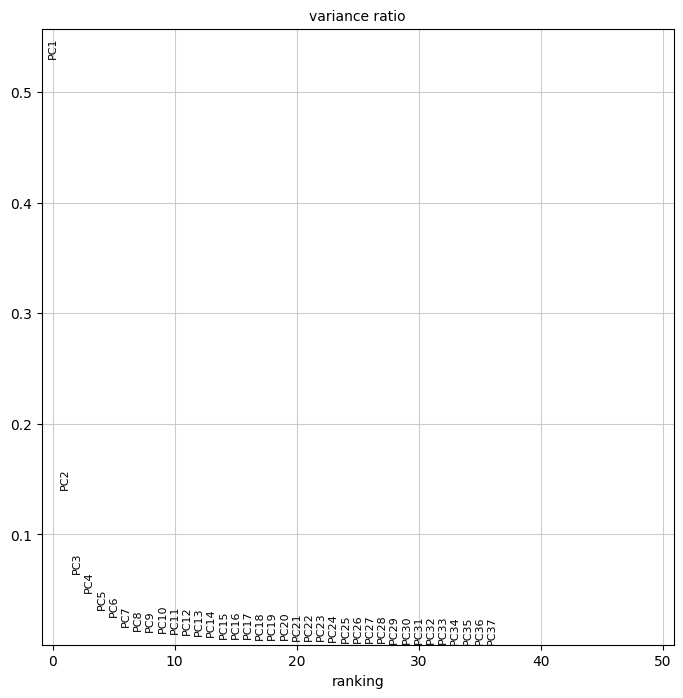

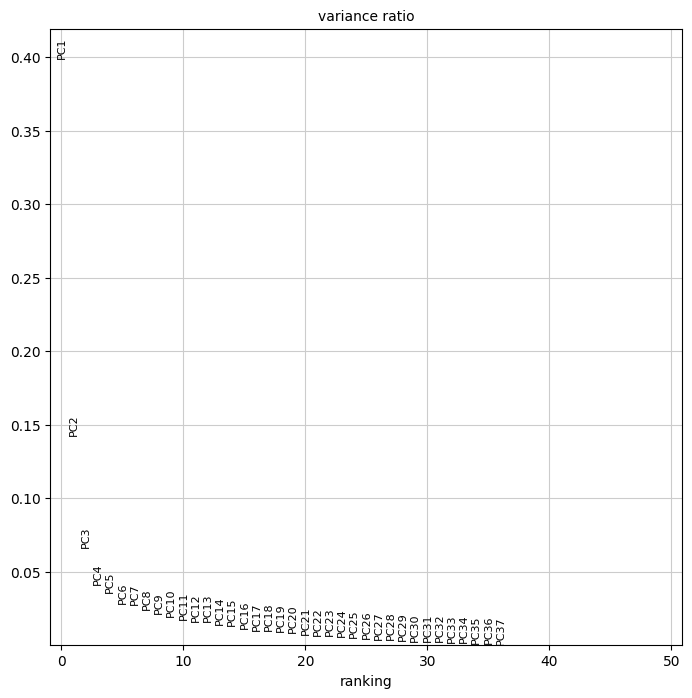

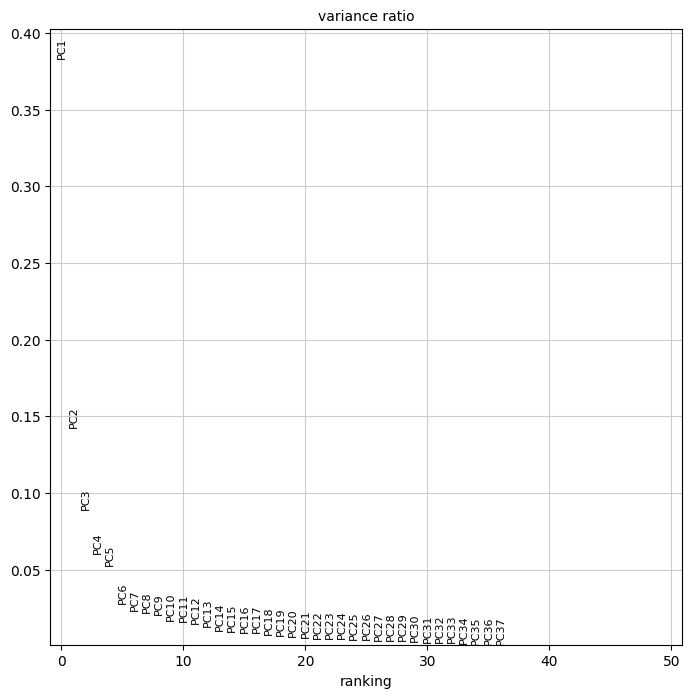

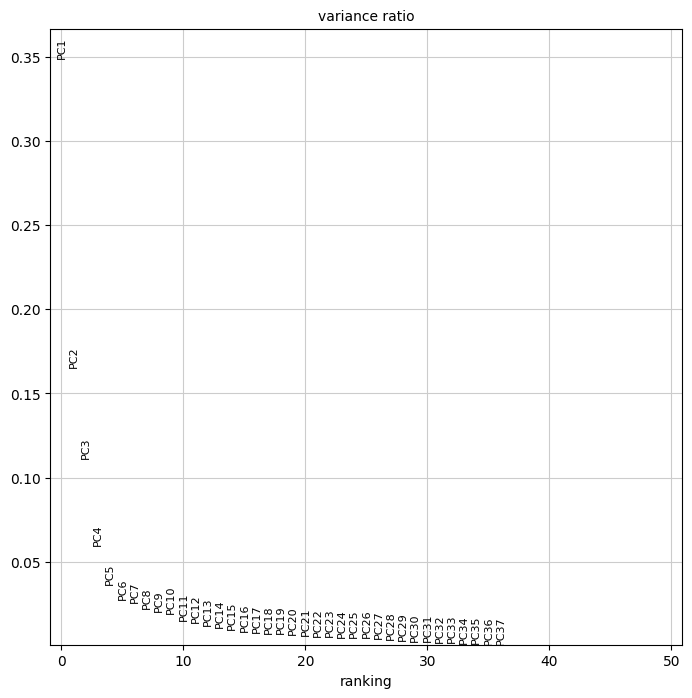

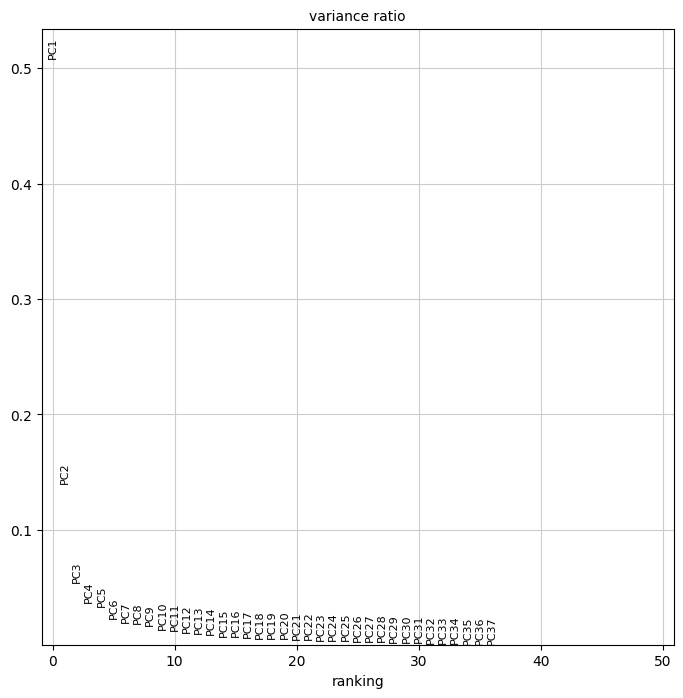

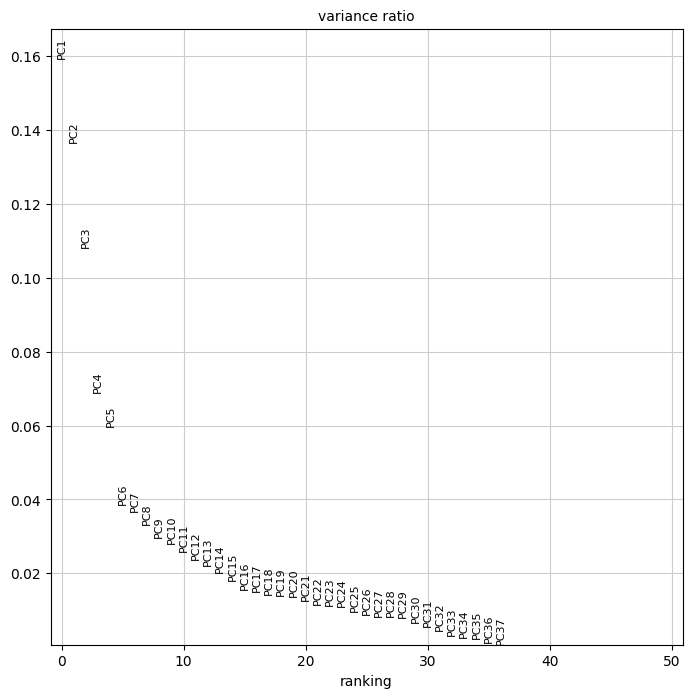

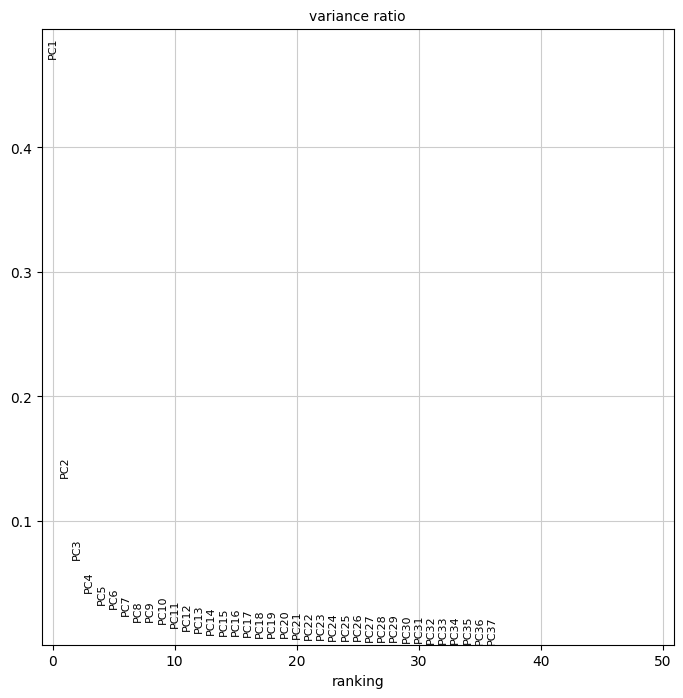

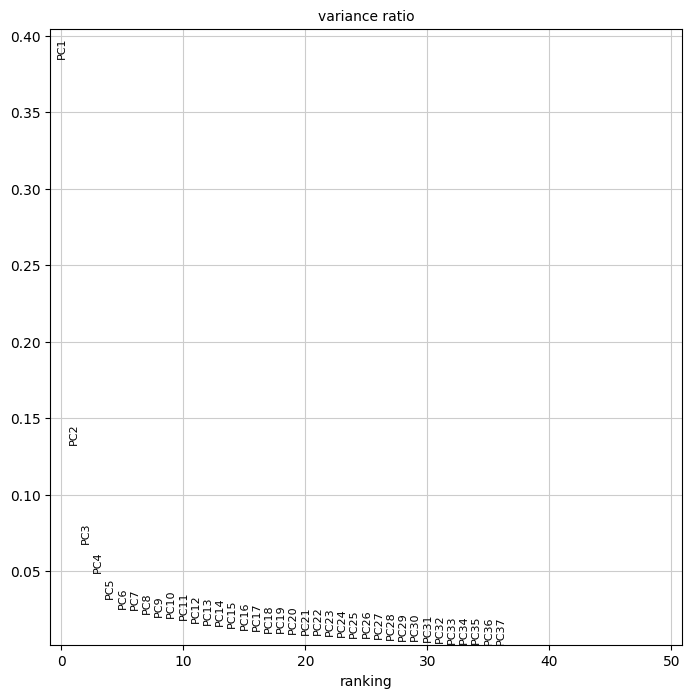

In [9]:
pc(P_ROI6_zscore, P_ROI8_zscore, P_ROI10_zscore, P_ROI12_zscore, P_ROI14_zscore, P_ROI15_zscore, P_ROI19_zscore, P_ROI22_zscore)

In [10]:
pc_6 = 3
pc_8 = 4
pc_10 = 5
pc_12 = 5
pc_14 = 3
pc_15 = 7
pc_19 = 4
pc_22 = 4

## UMAP

In [11]:
def umap(data1, pc1, data2, pc2, data3, pc3, data4, pc4, data5, pc5, data6, pc6, data7, pc7, data8, pc8):
    sc.settings.set_figure_params(dpi=100, fontsize=12,figsize=(10,10))
    # Computing the neighborhood graph
    sc.pp.neighbors(data1, n_neighbors=15, n_pcs=pc1)
    sc.tl.umap(data1, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data1,resolution=1.1, key_added = "leiden")
         
    sc.pp.neighbors(data2, n_neighbors=15, n_pcs=pc2)
    sc.tl.umap(data2, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data2,resolution=1.1, key_added = "leiden")
         
    sc.pp.neighbors(data3, n_neighbors=15, n_pcs=pc3)
    sc.tl.umap(data3, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data3,resolution=0.87, key_added = "leiden")               
             
    sc.pp.neighbors(data4, n_neighbors=15, n_pcs=pc4)
    sc.tl.umap(data4, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data4,resolution=1, key_added = "leiden") 
             
    sc.pp.neighbors(data5, n_neighbors=15, n_pcs=pc5)
    sc.tl.umap(data5, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data5,resolution=1.1, key_added = "leiden")    
             
    sc.pp.neighbors(data6, n_neighbors=15, n_pcs=pc6)
    sc.tl.umap(data6, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data6,resolution=1.3, key_added = "leiden")
                            
    sc.pp.neighbors(data7, n_neighbors=15, n_pcs=pc7)
    sc.tl.umap(data7, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data7,resolution=1.1, key_added = "leiden")  
             
    sc.pp.neighbors(data8, n_neighbors=15, n_pcs=pc8)
    sc.tl.umap(data8, random_state=0, min_dist=0, spread=1) 
    sc.tl.leiden(data8,resolution=1.35, key_added = "leiden")
         
        
    
    #plot results
    sc.pl.umap(data1, color ='leiden', s=20, use_raw=False, title = 'ROI6', save=  'ROI6.png')
    sc.pl.umap(data2, color ='leiden', s=20, use_raw=False, title = 'ROI8', save=  'ROI8.png')
    sc.pl.umap(data3, color ='leiden', s=20, use_raw=False, title = 'ROI10', save= 'ROI10.png')
    sc.pl.umap(data4, color ='leiden', s=20, use_raw=False, title = 'ROI12', save= 'ROI12.png')
    sc.pl.umap(data5, color ='leiden', s=20, use_raw=False, title = 'ROI14', save= 'ROI14.png')
    sc.pl.umap(data6, color ='leiden', s=20, use_raw=False, title = 'ROI15', save= 'ROI15.png')
    sc.pl.umap(data7, color ='leiden', s=20, use_raw=False, title = 'ROI18', save= 'ROI19.png')
    sc.pl.umap(data8, color ='leiden', s=20, use_raw=False, title = 'ROI22', save= 'ROI22.png')

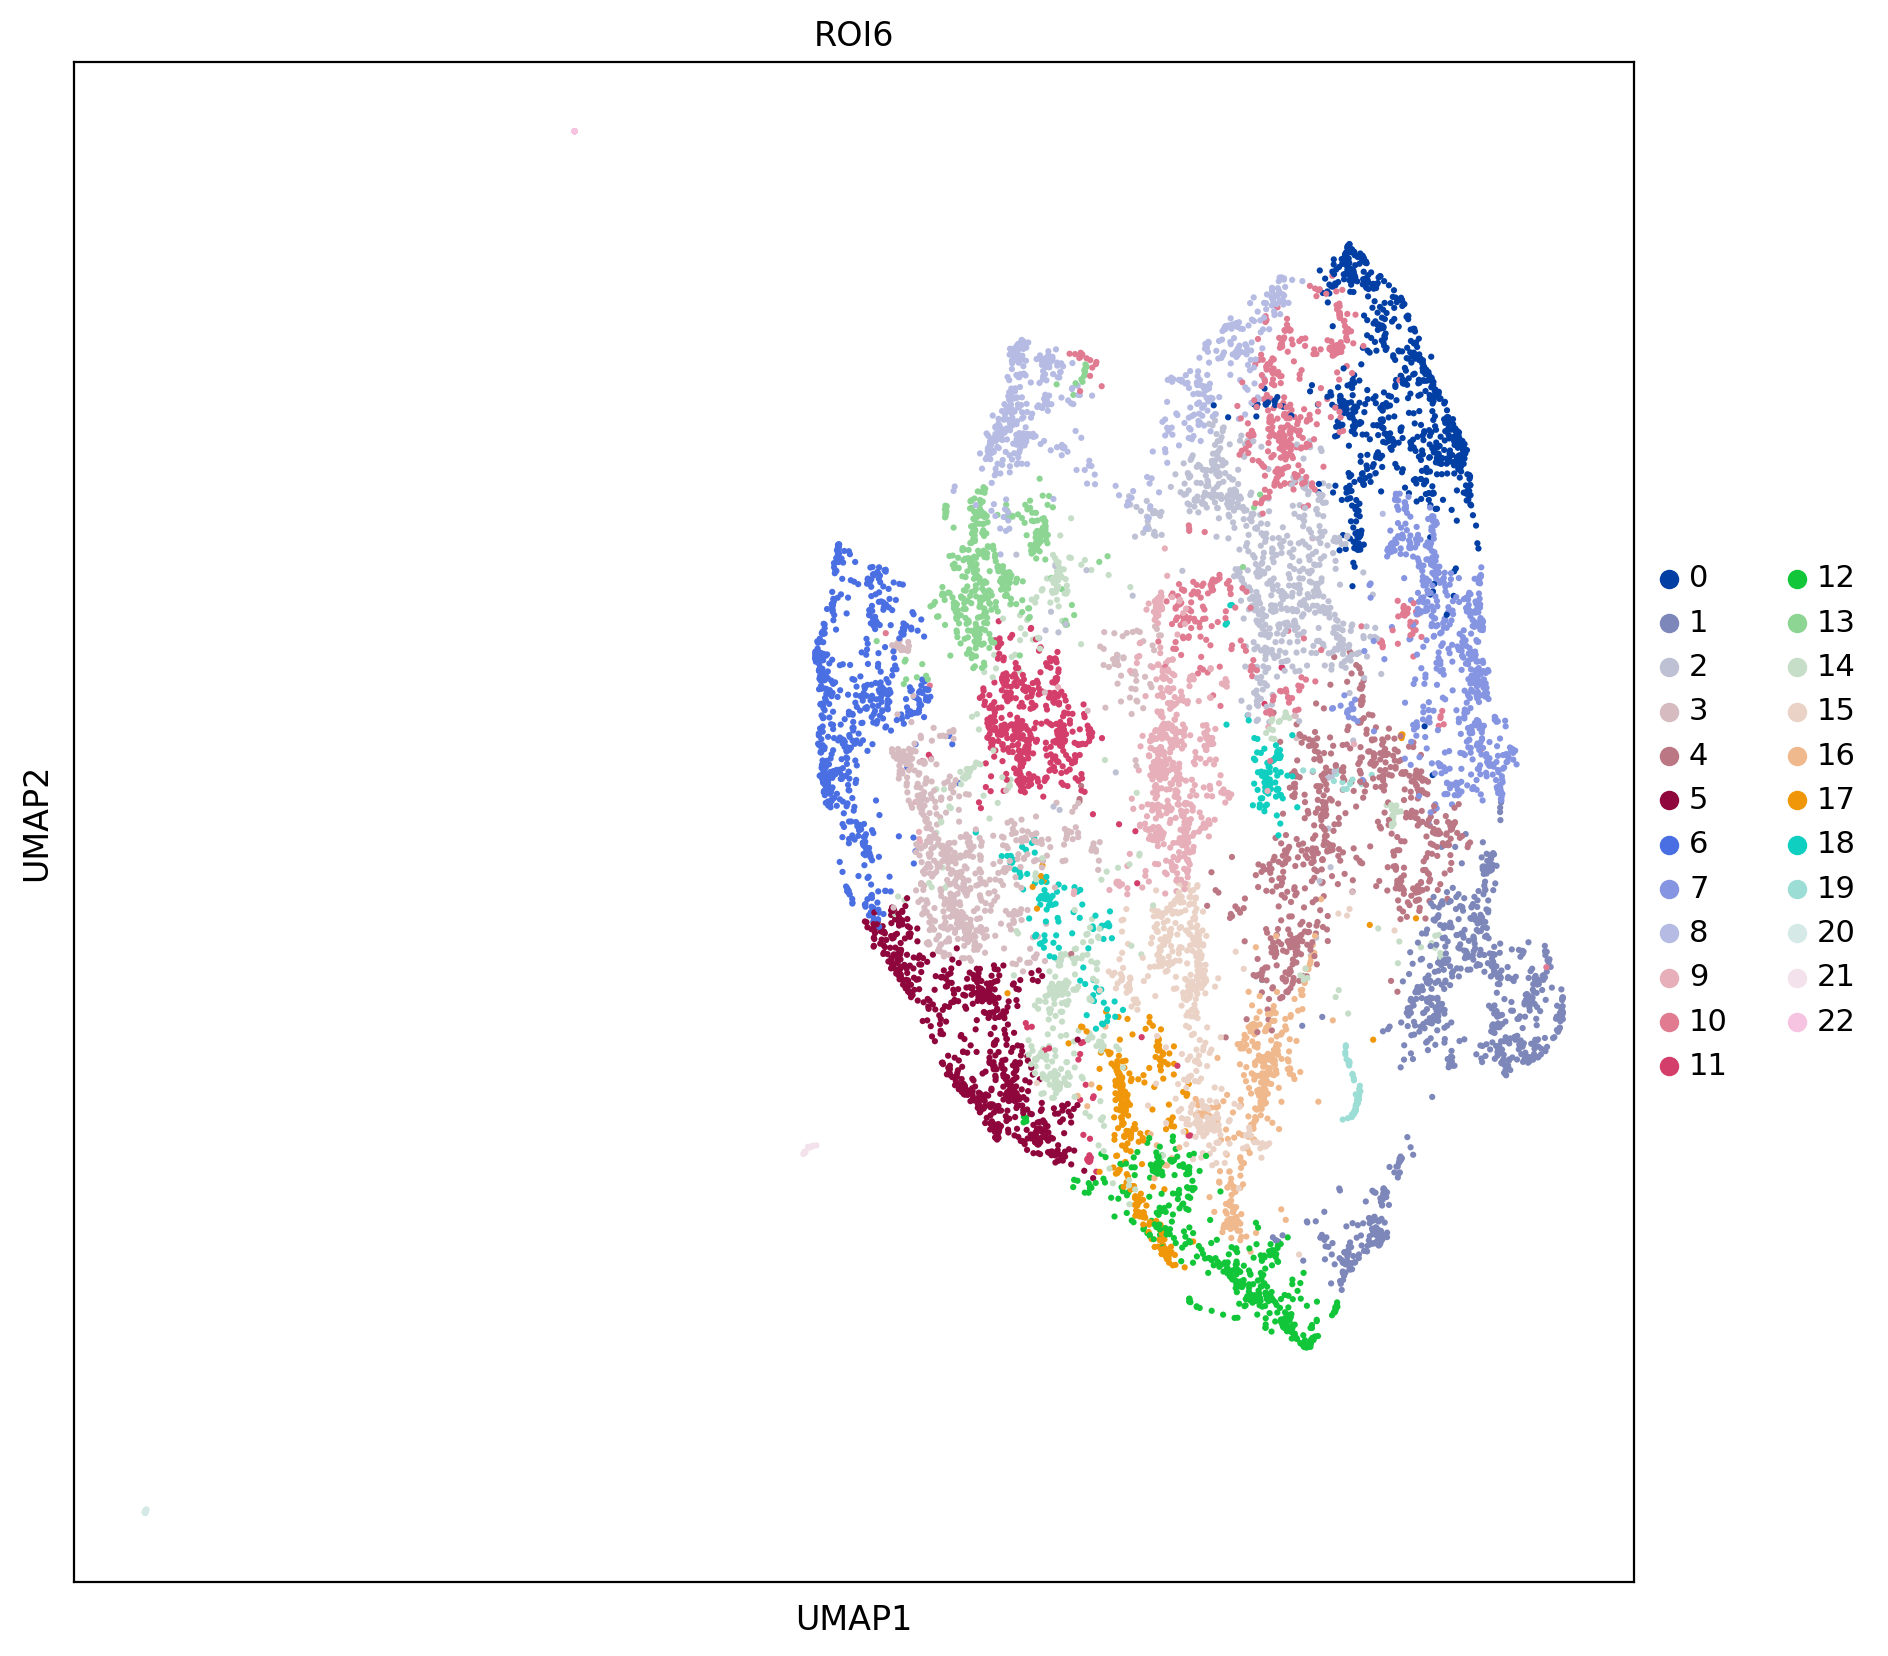

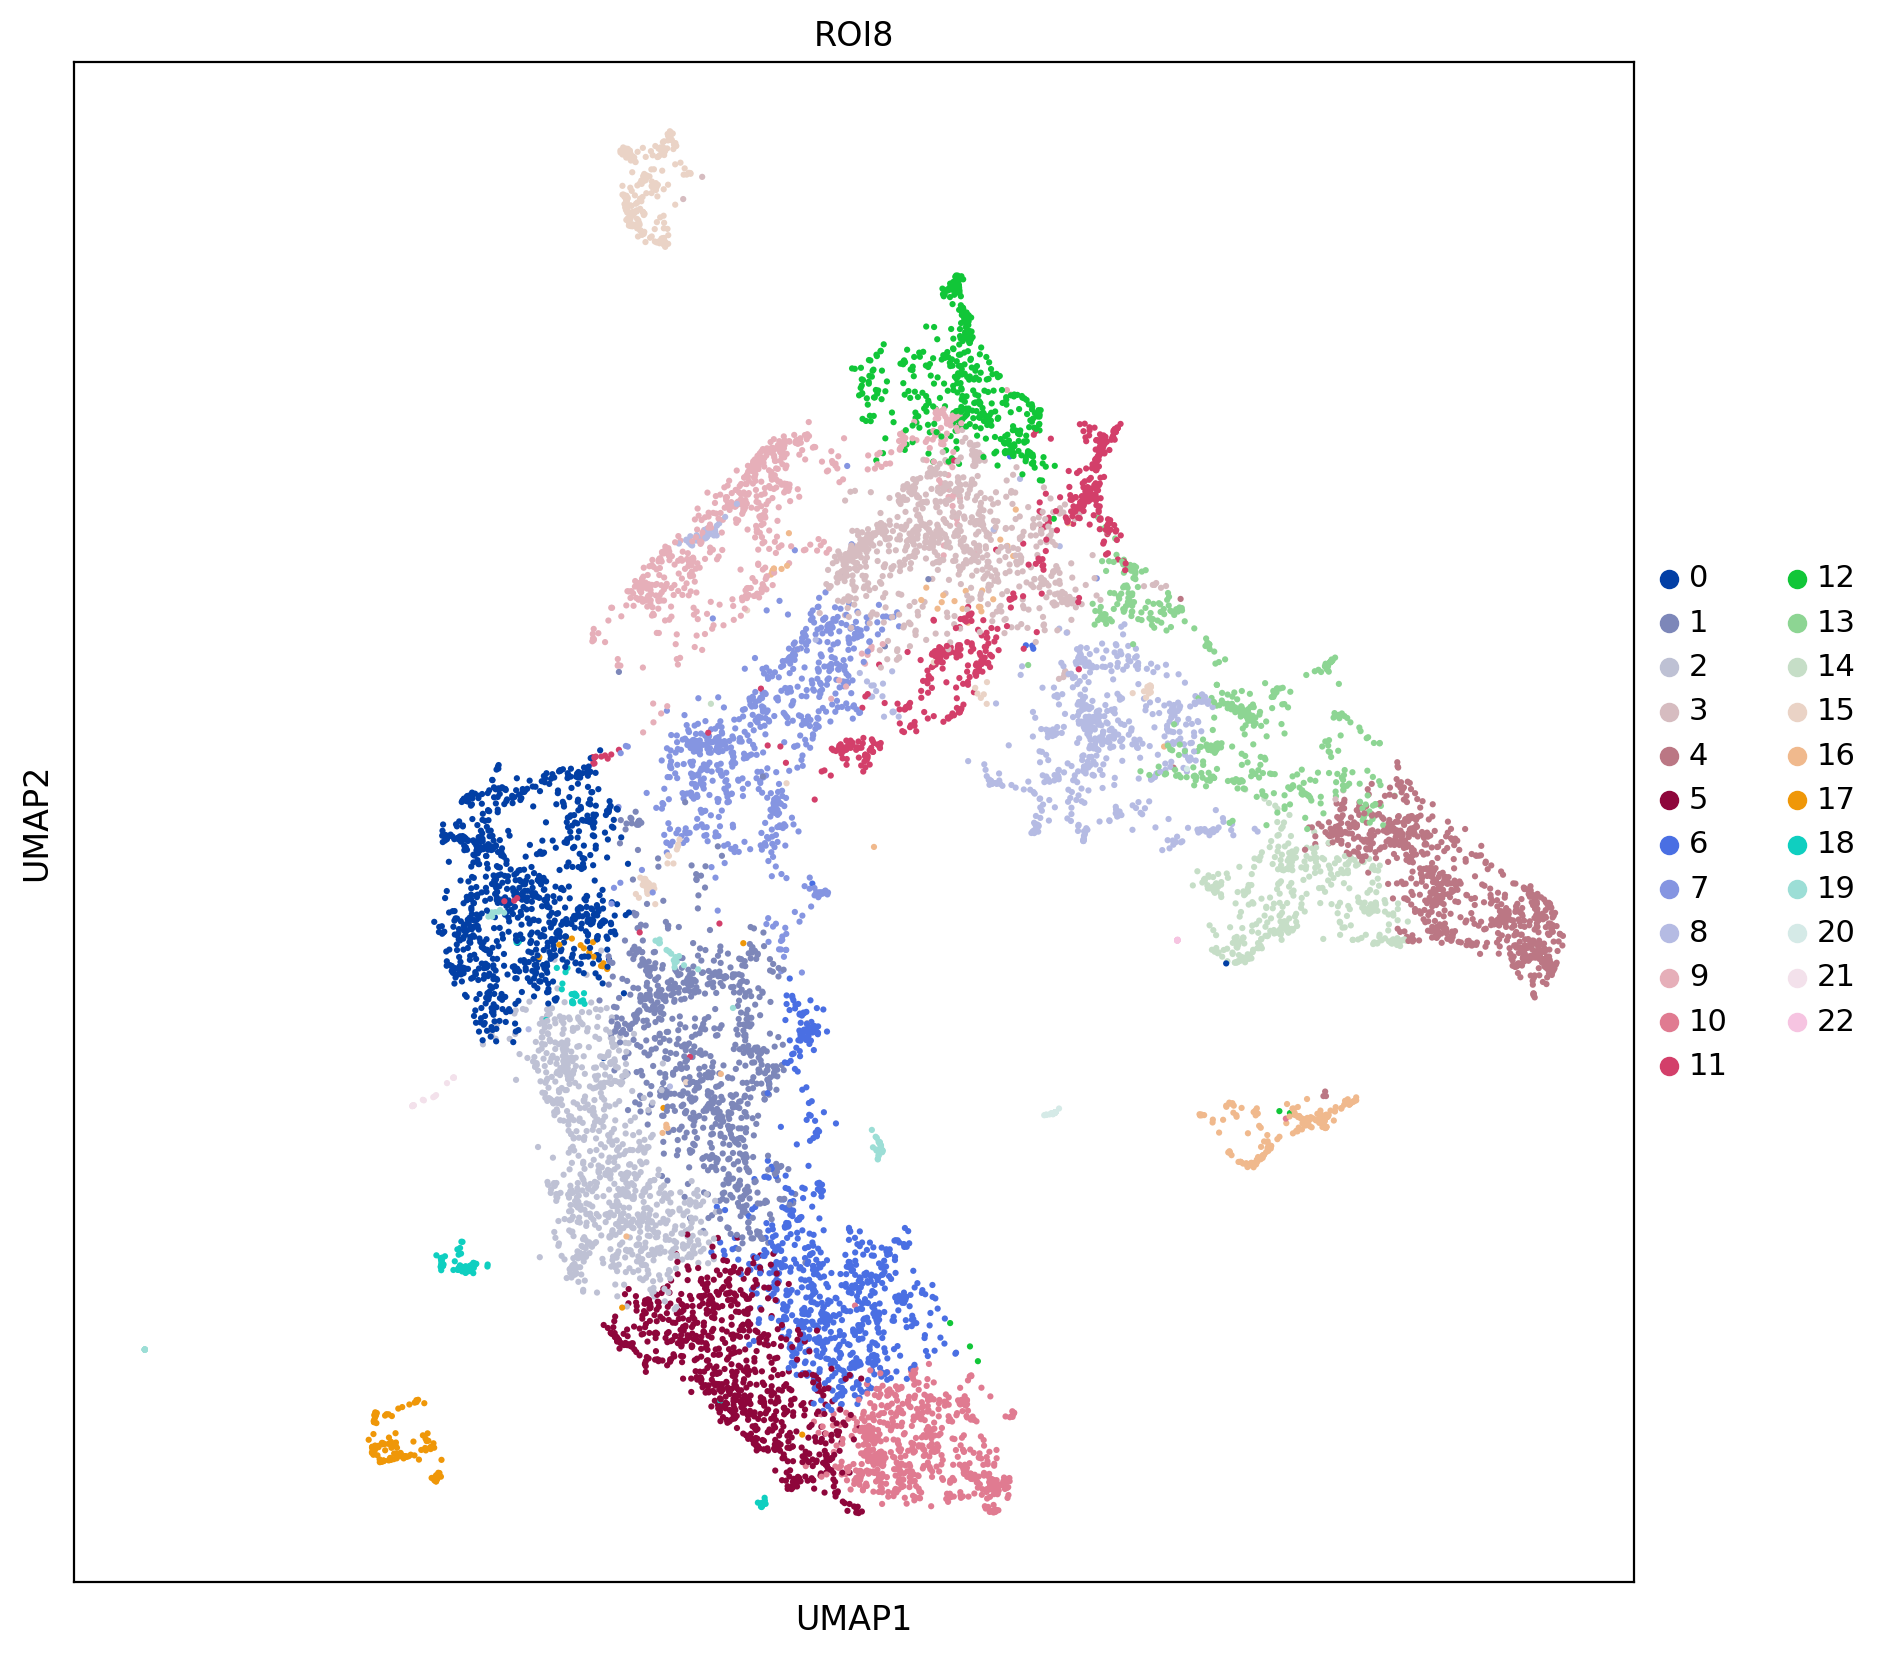

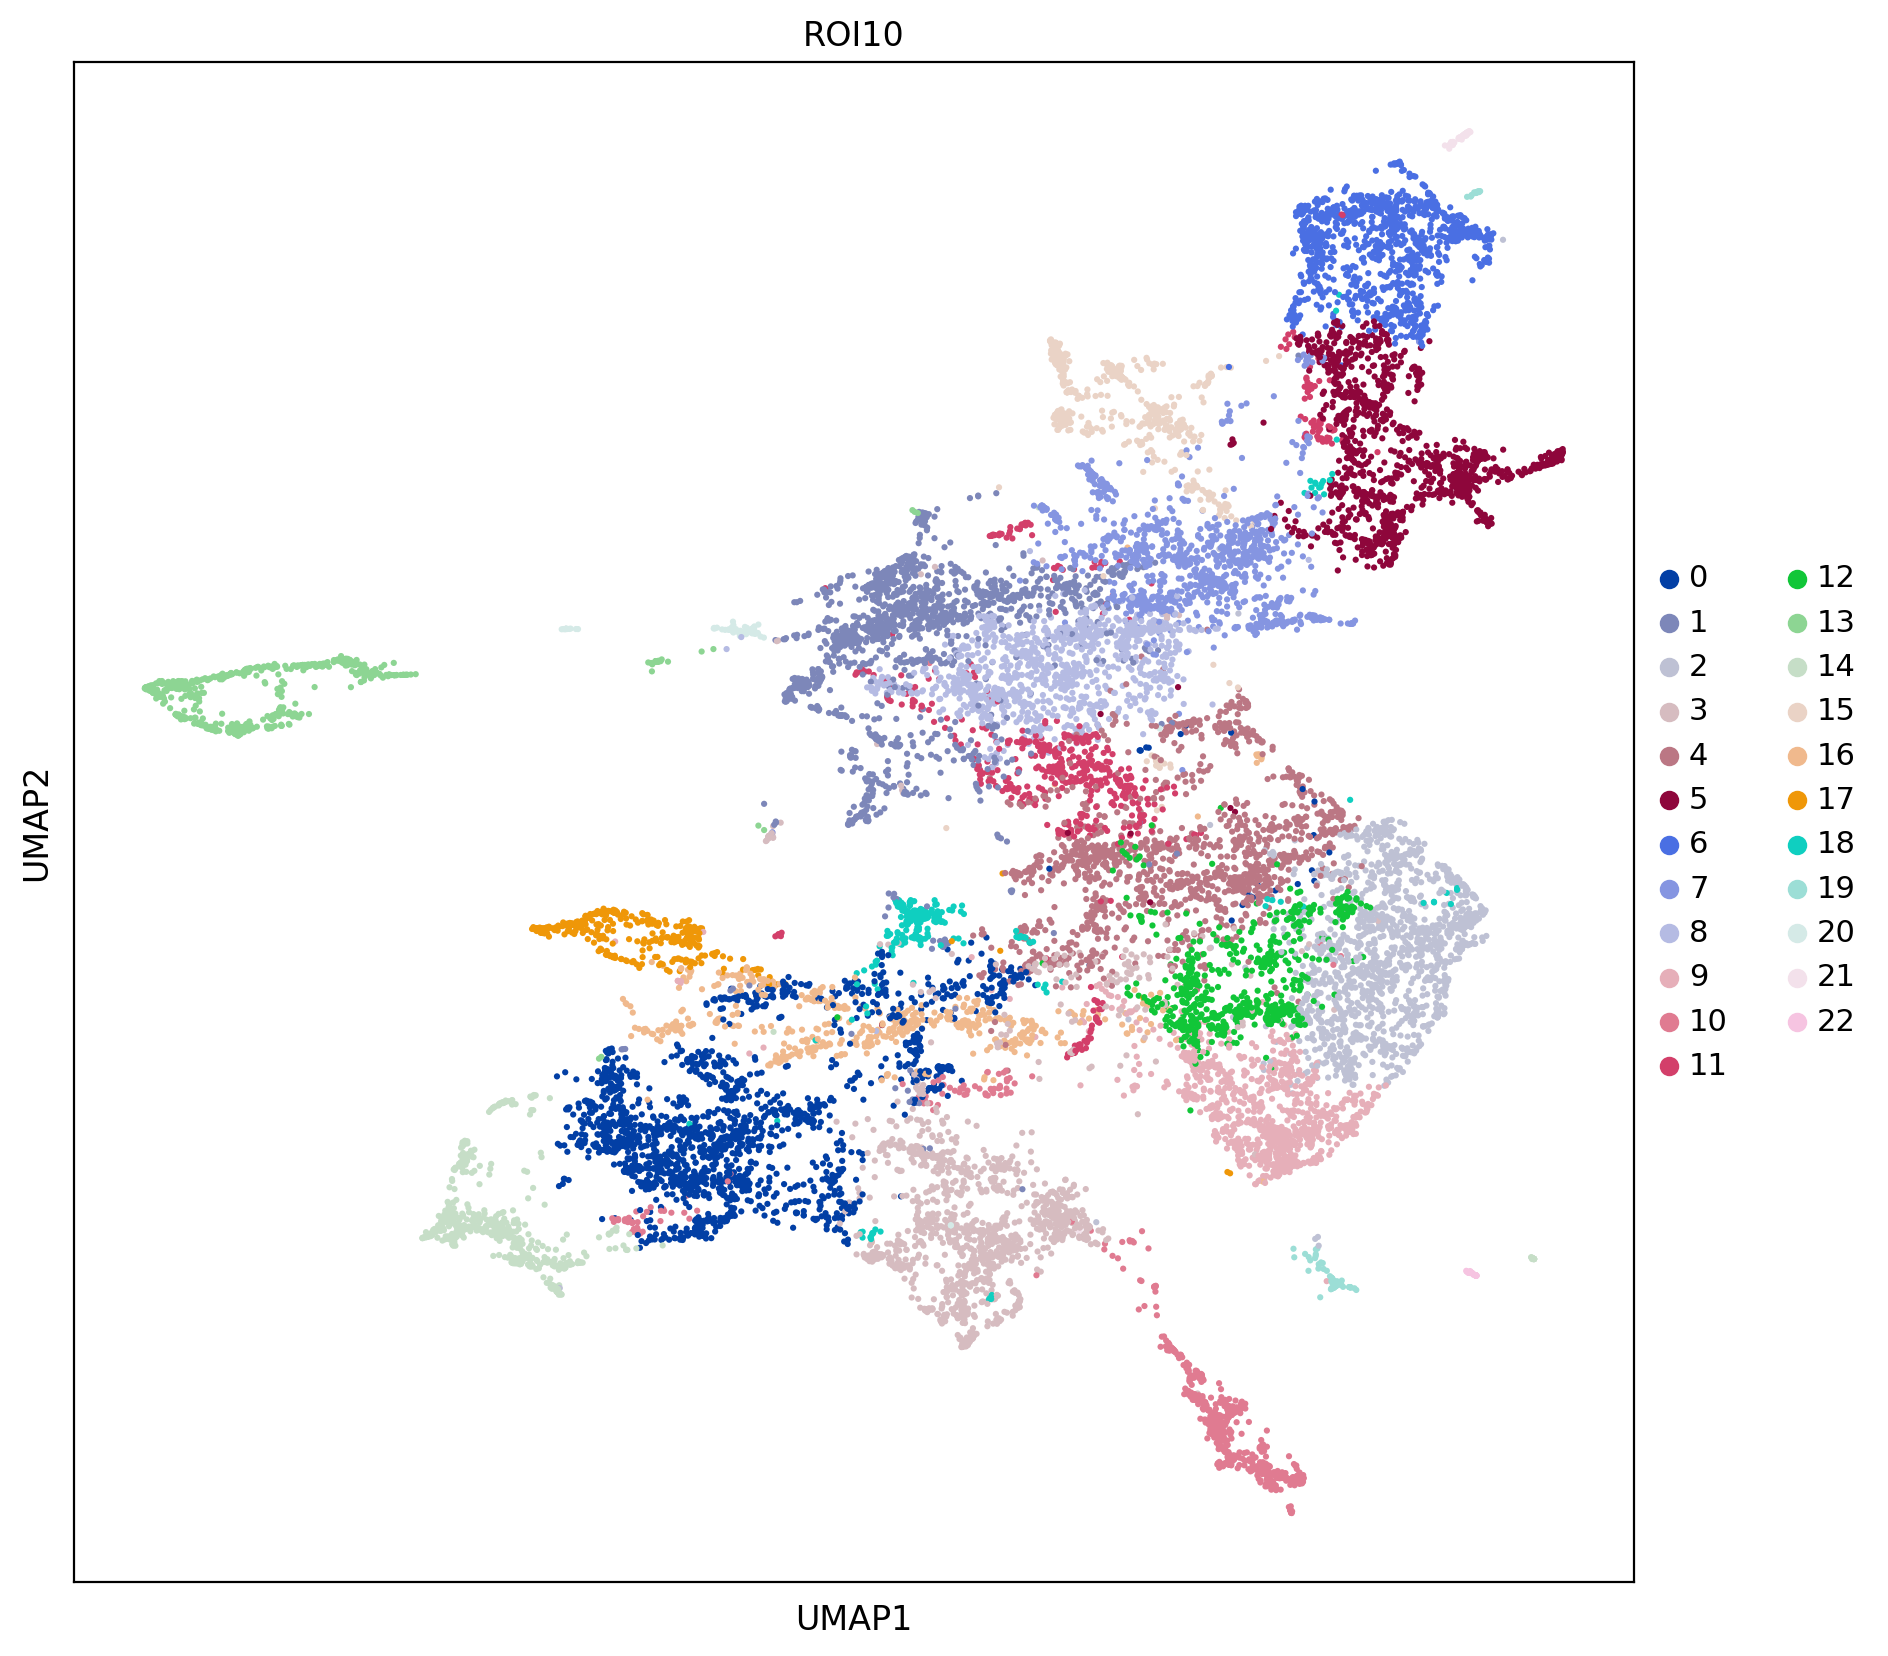

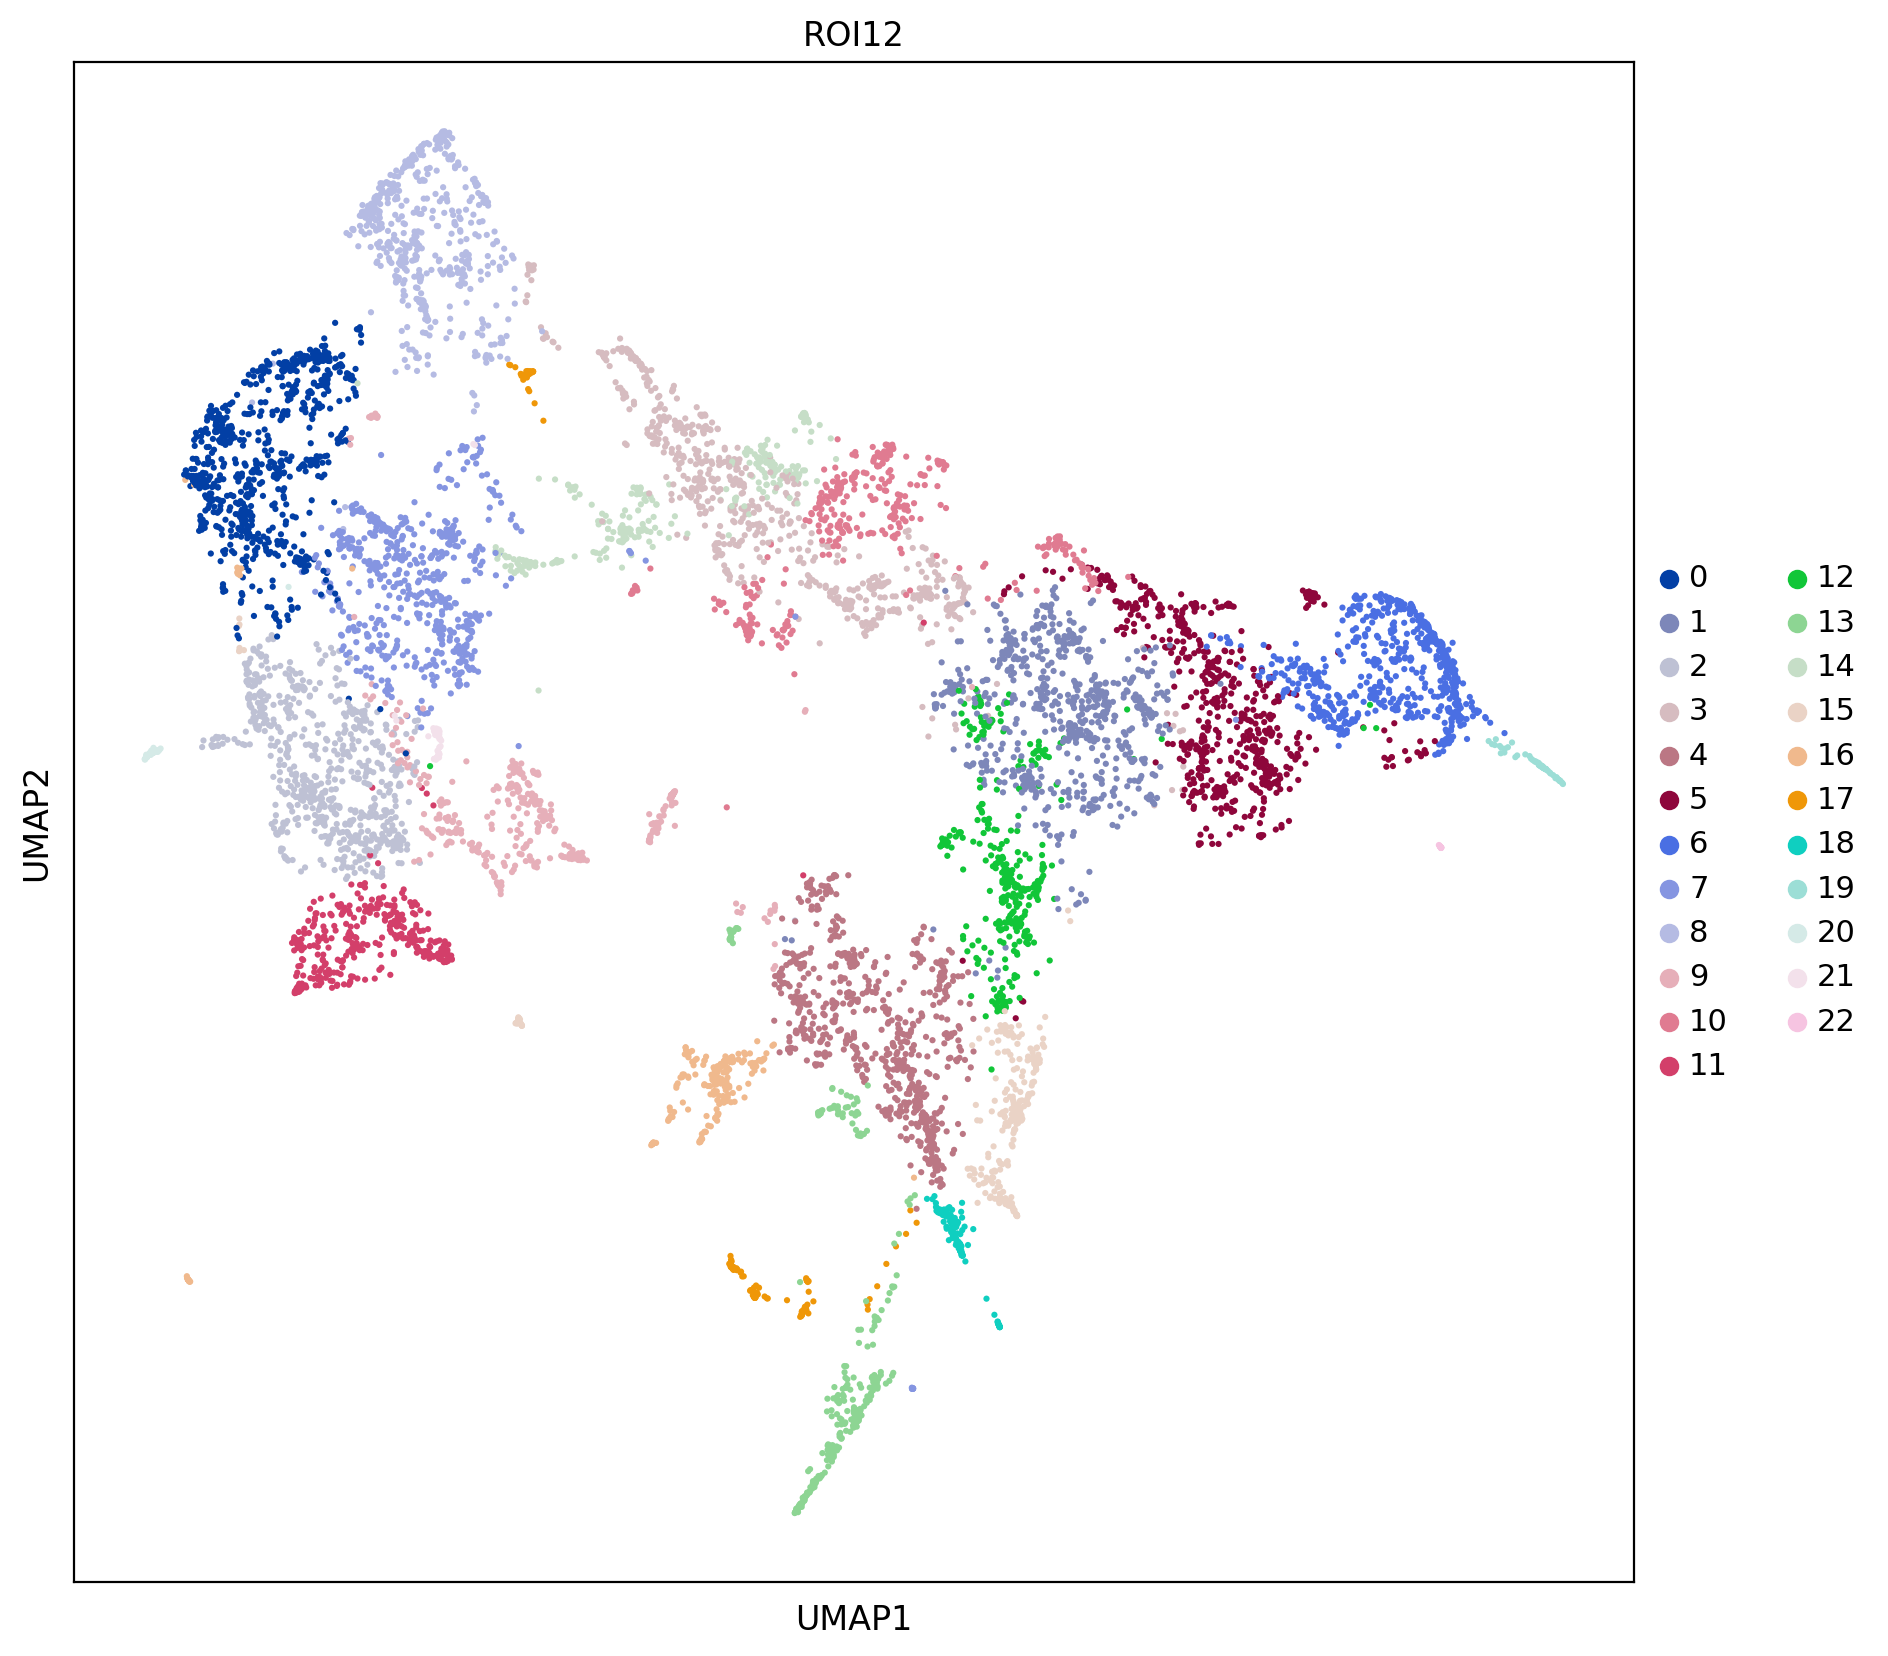

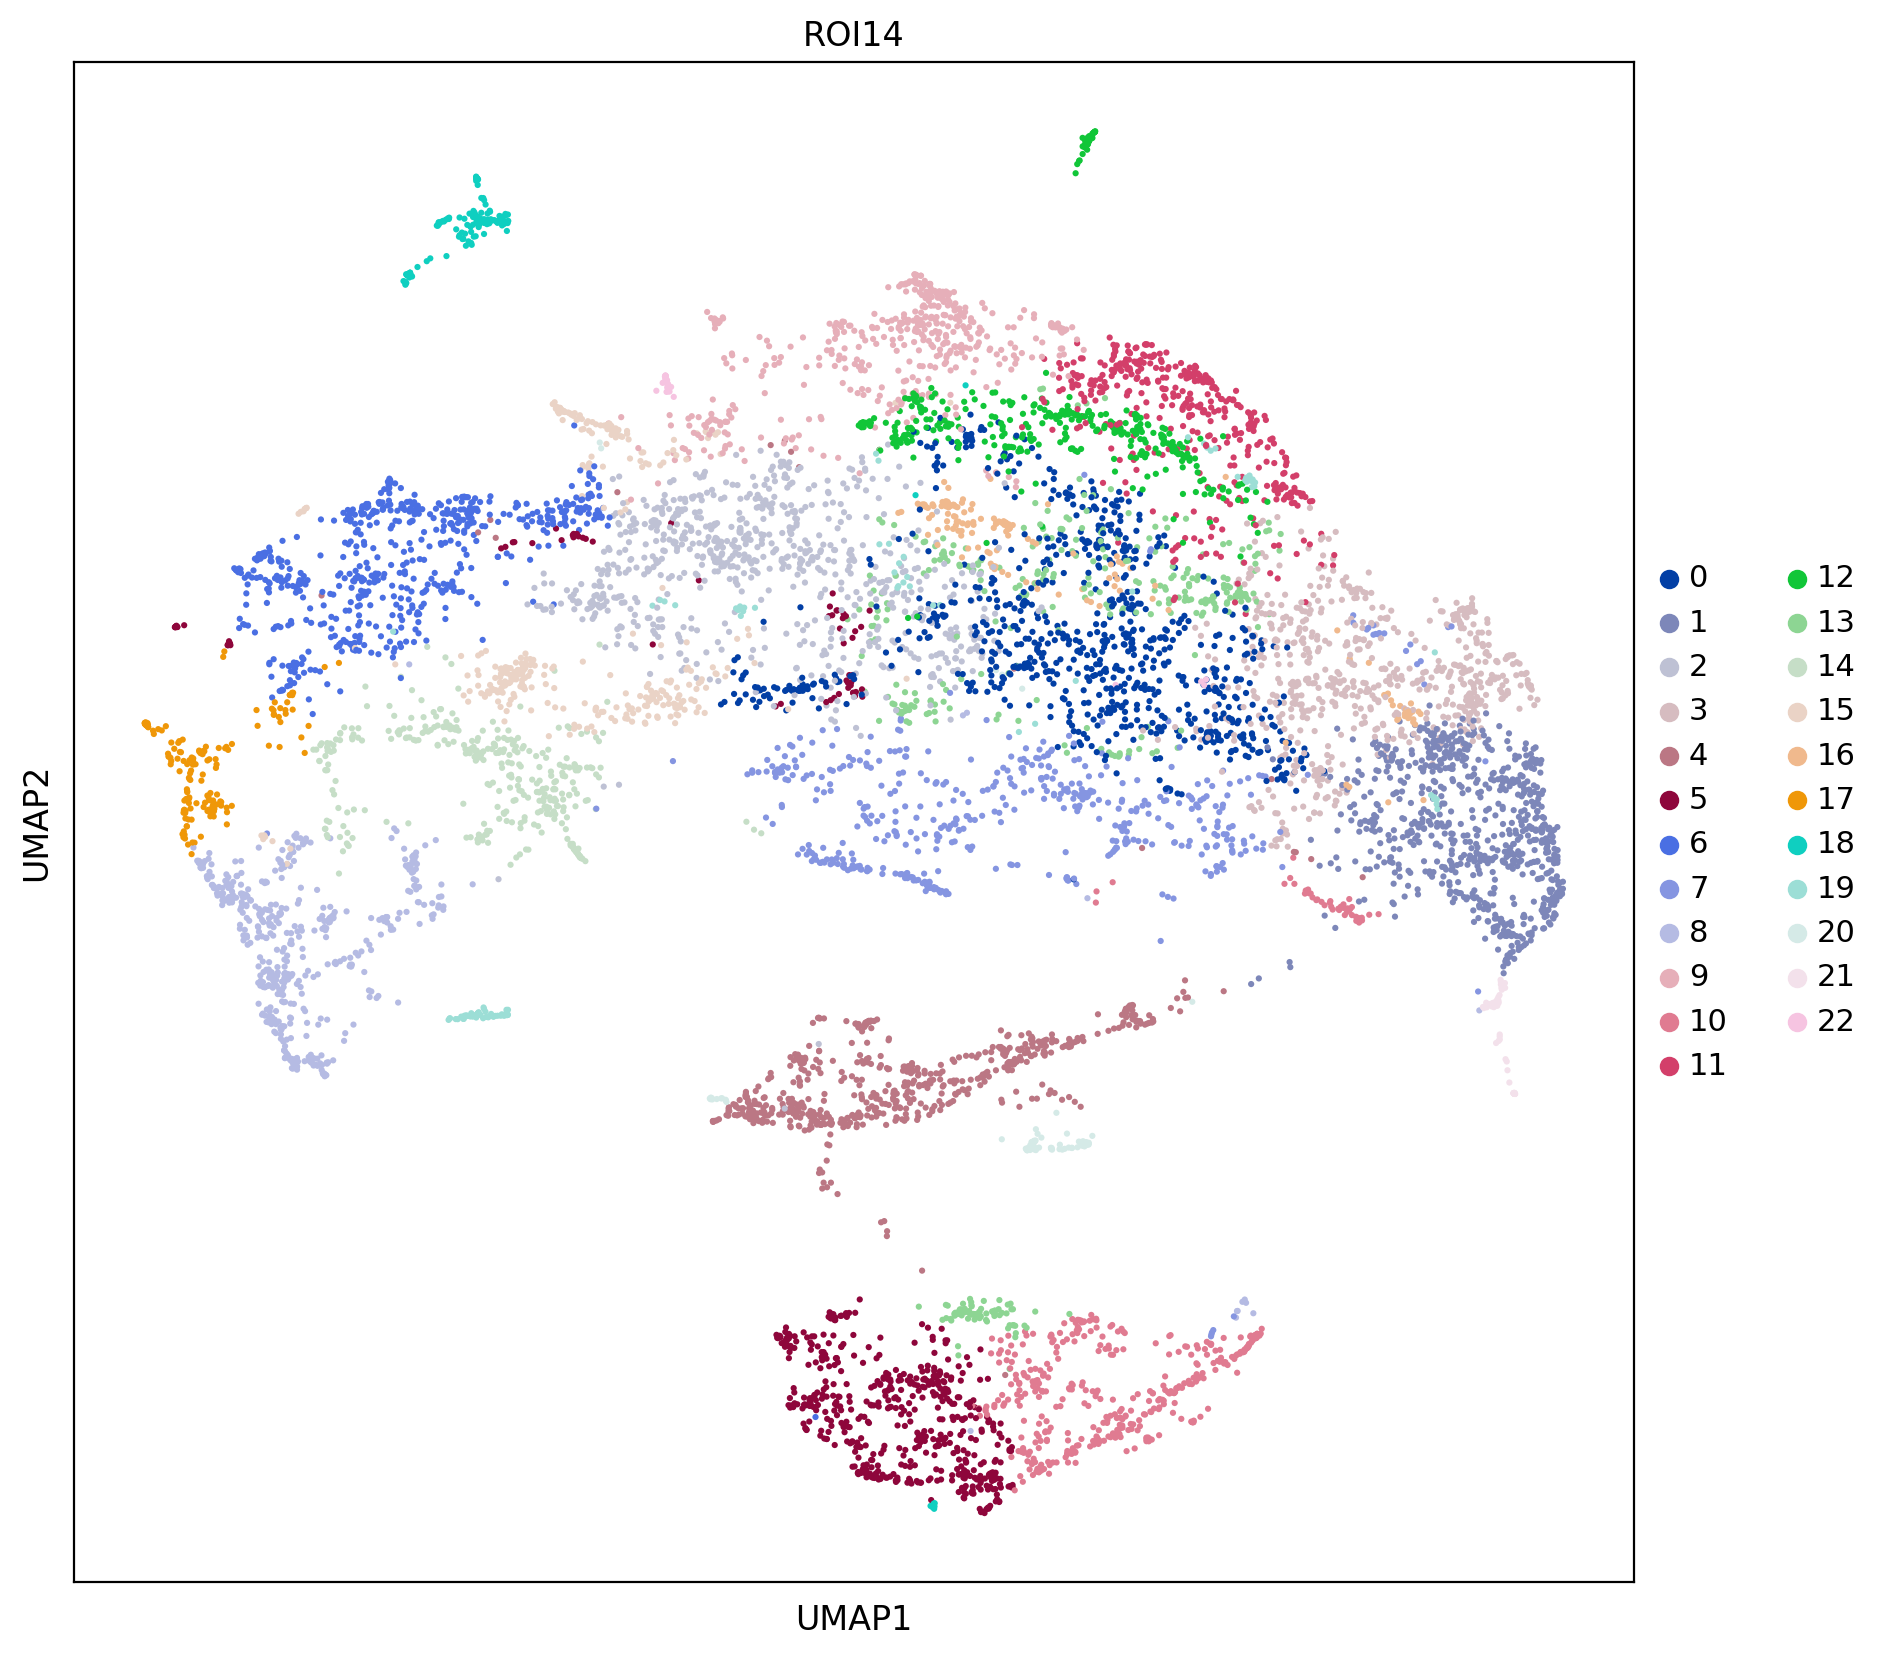

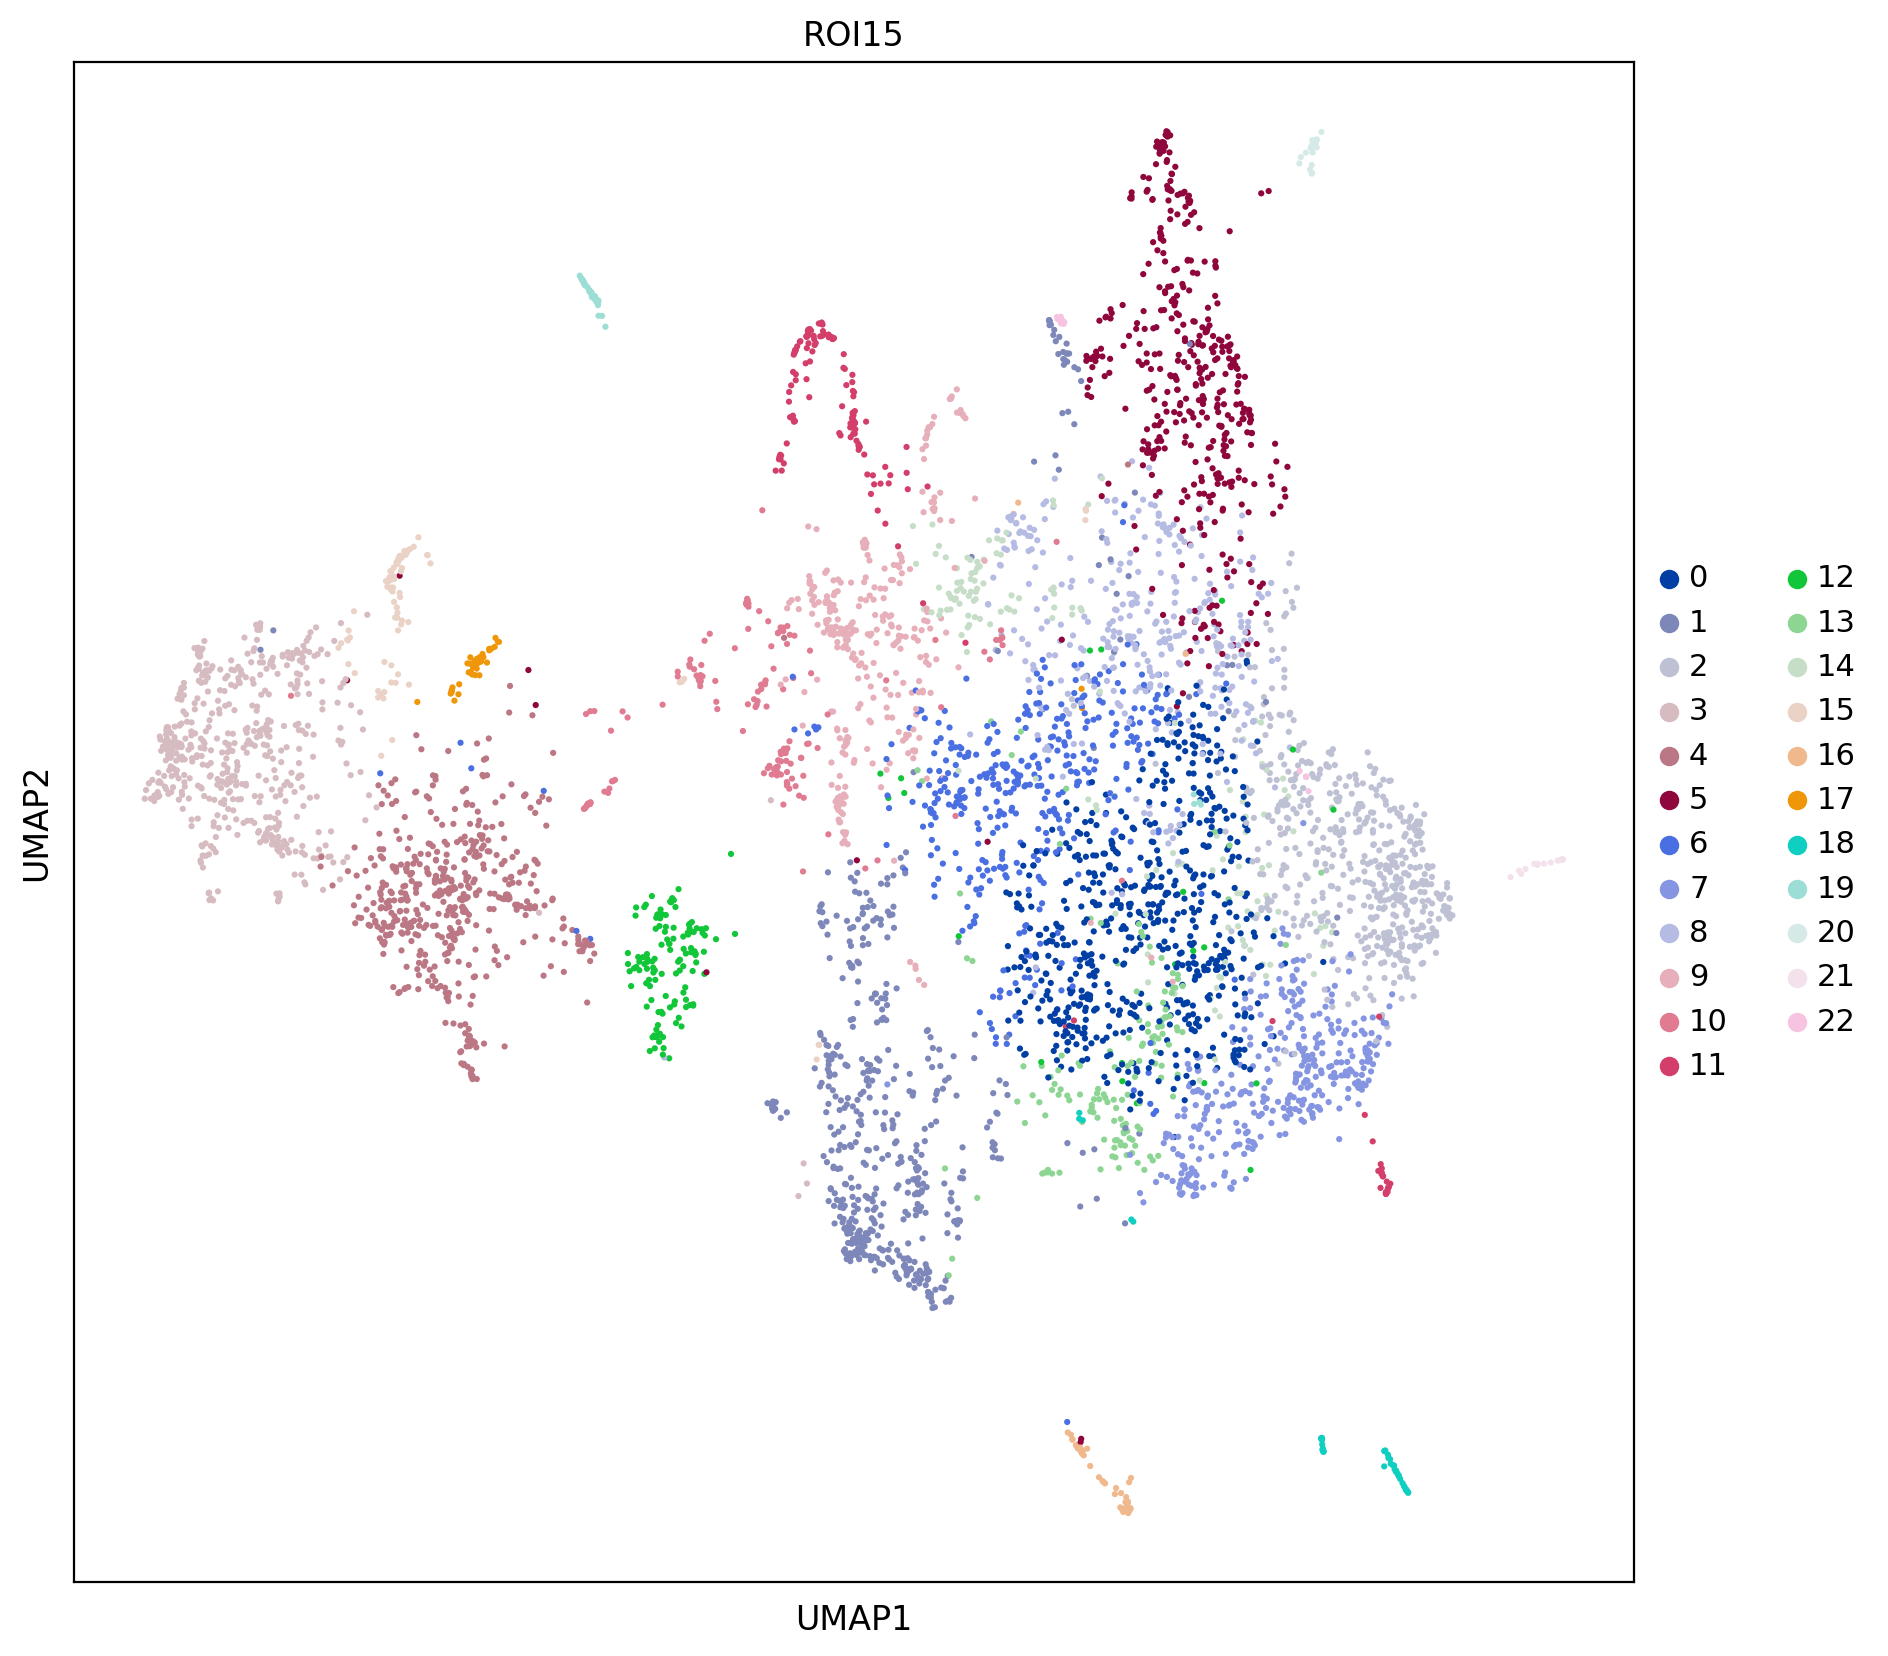

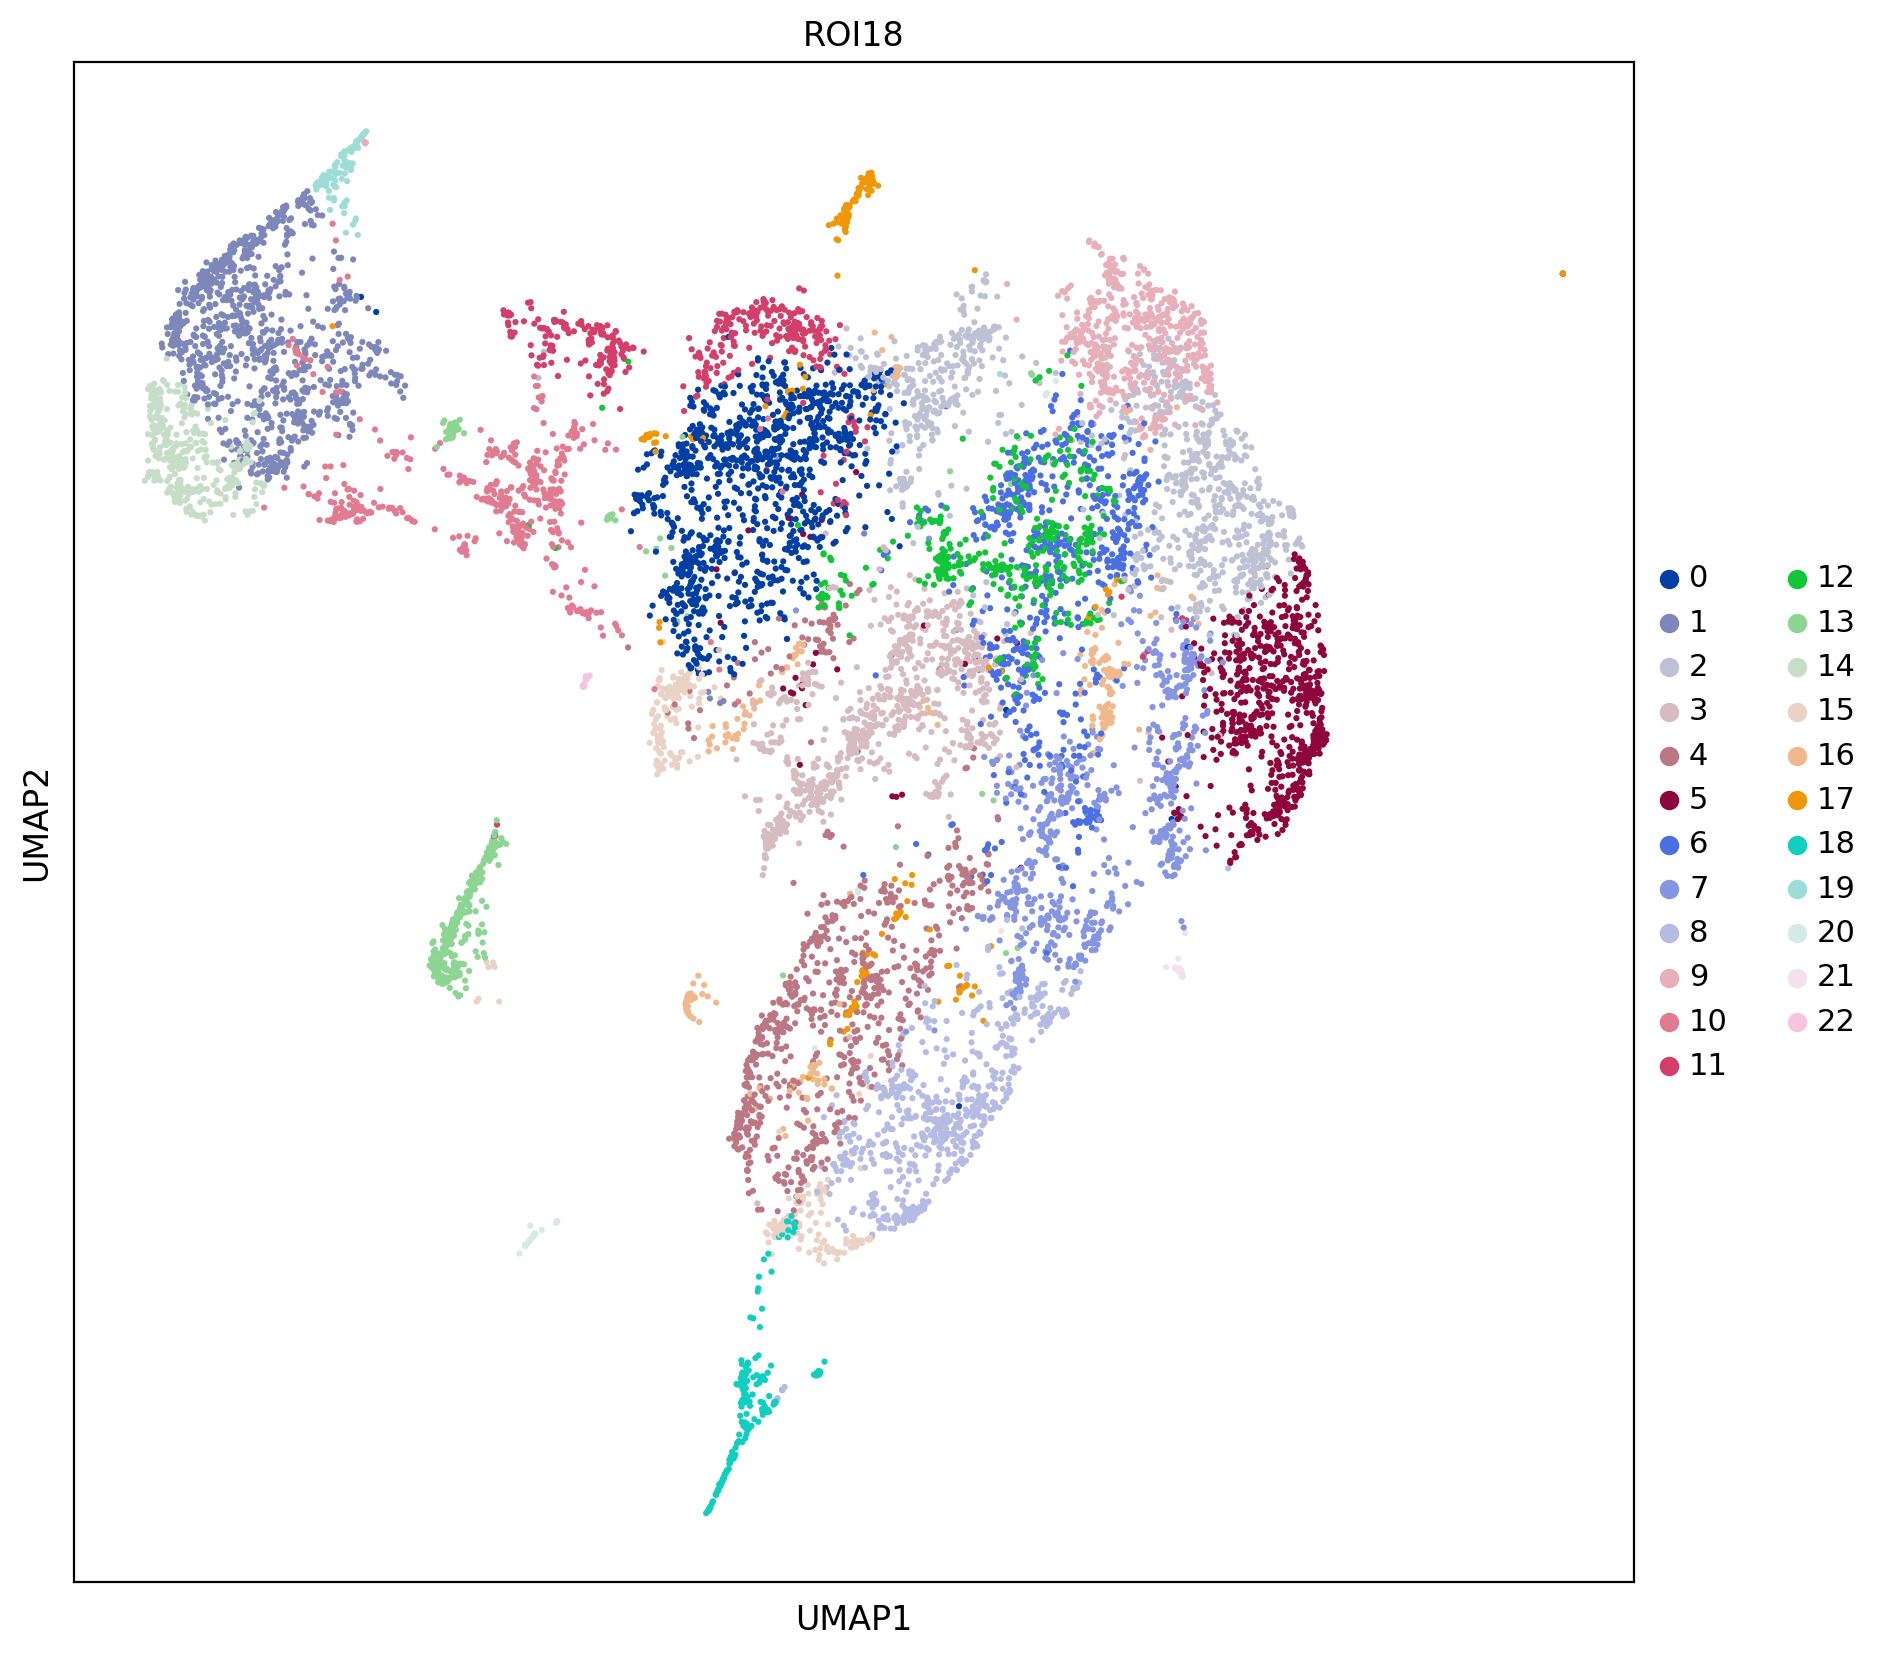

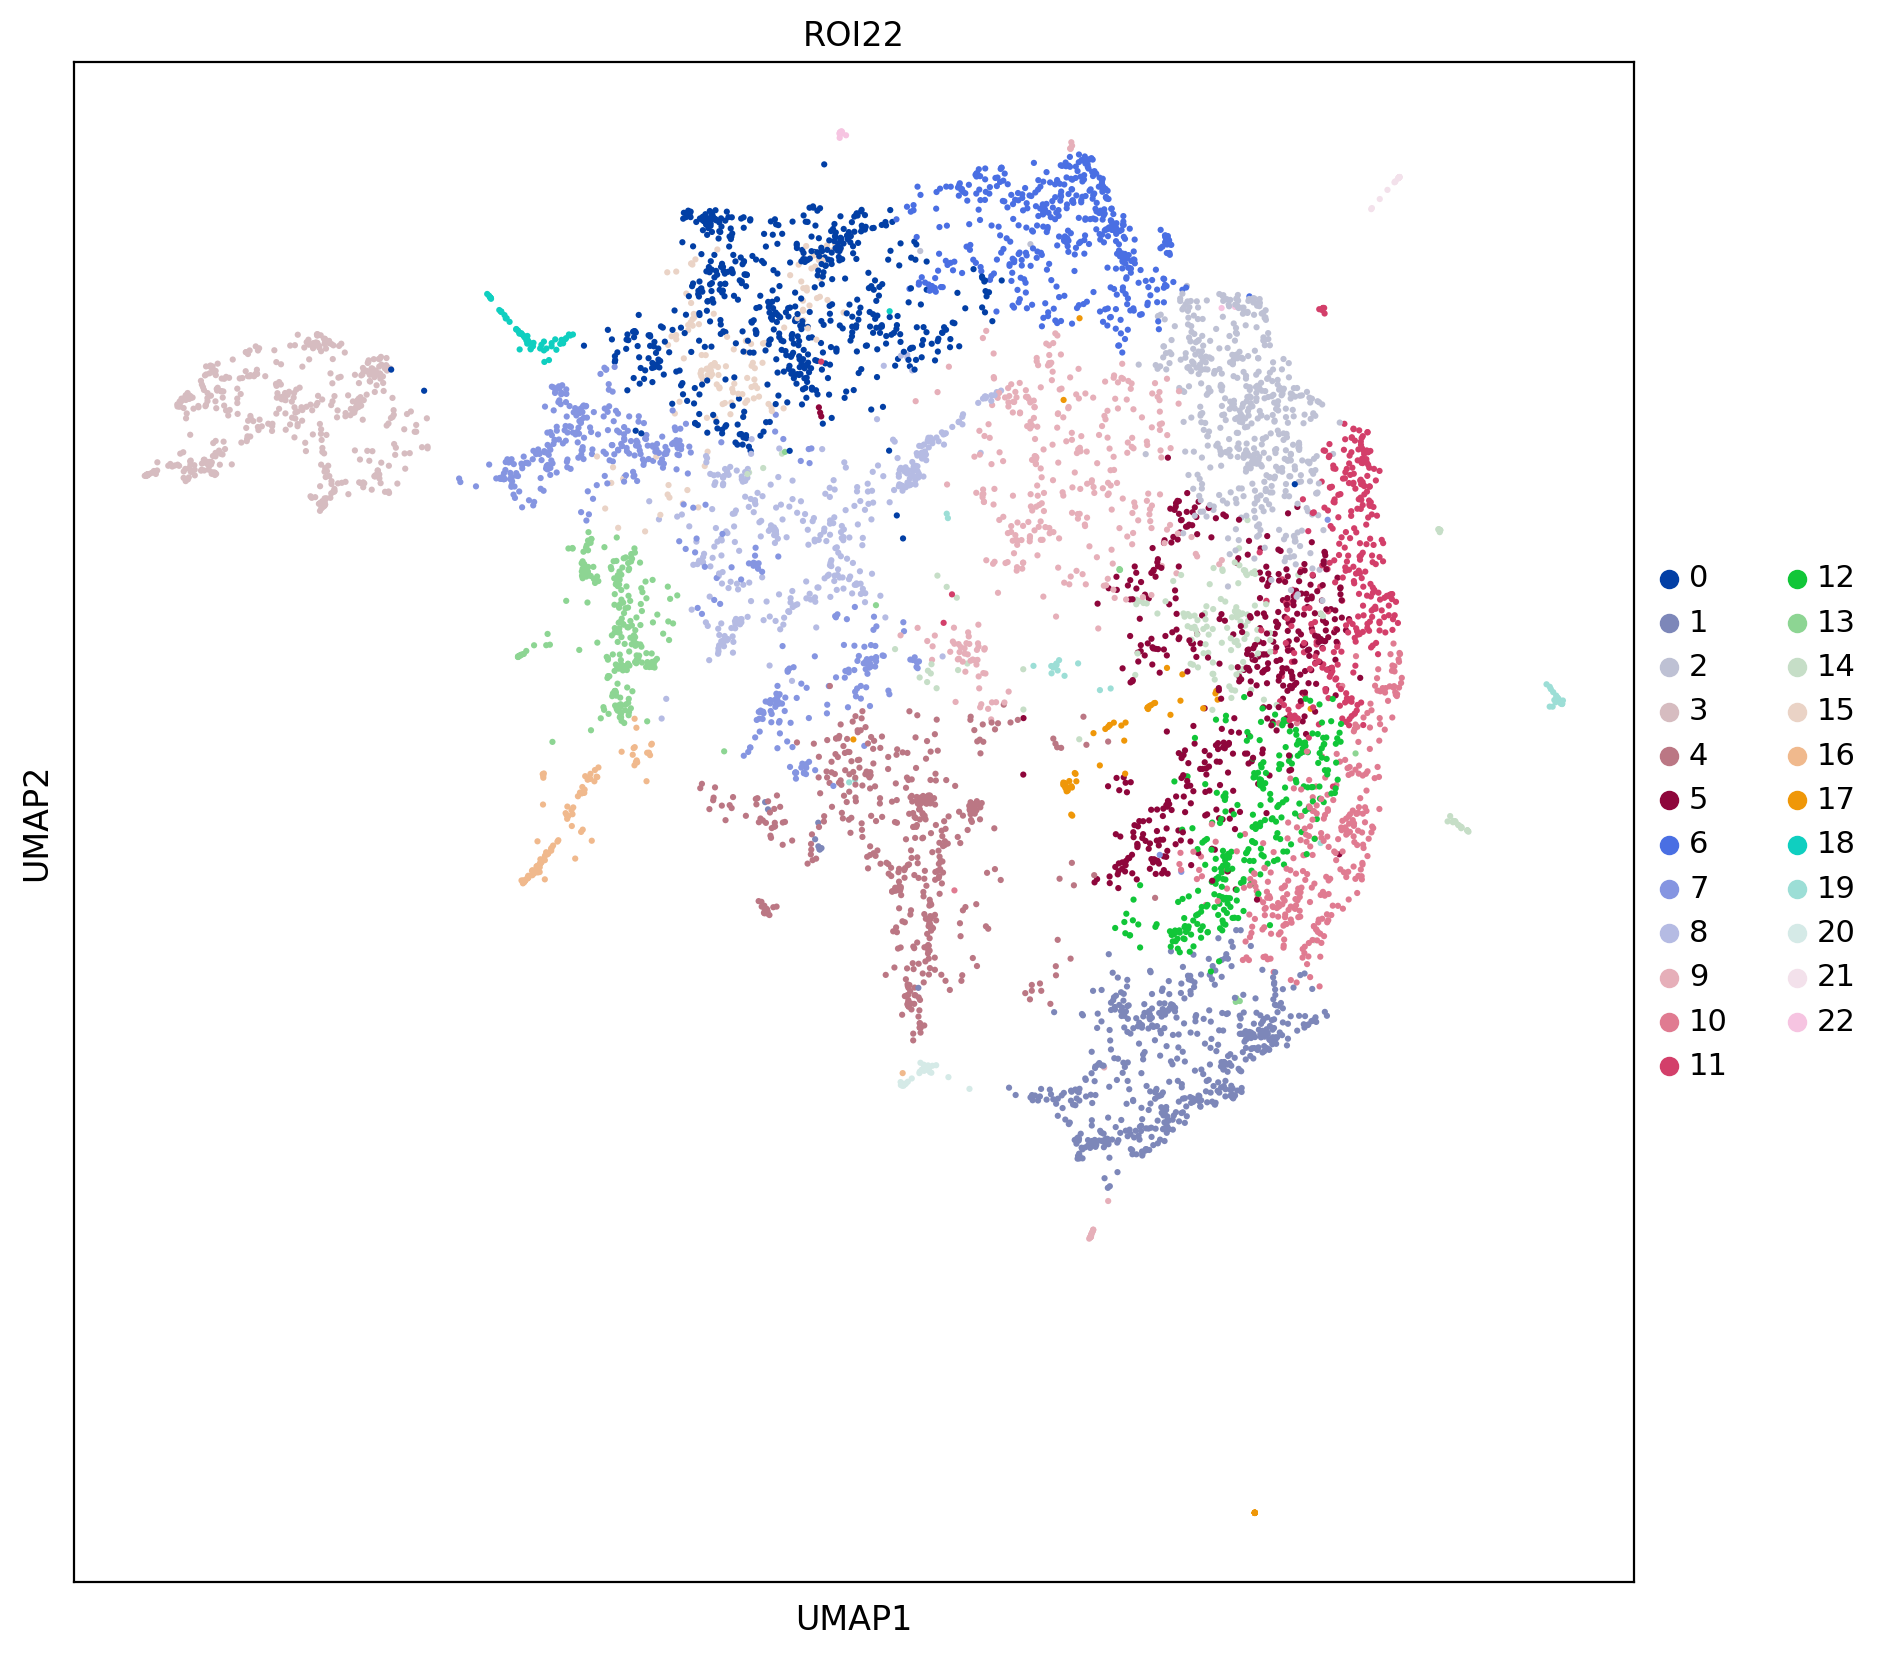

In [12]:
umap(P_ROI6_zscore, pc_6, P_ROI8_zscore, pc_8, P_ROI10_zscore, pc_10, P_ROI12_zscore, pc_12, P_ROI14_zscore, pc_14, P_ROI15_zscore, pc_15, P_ROI19_zscore, pc_19, P_ROI22_zscore, pc_22)

## Matrix plots

In [13]:
# median per cluster for heatmap
def median_cluster(data, numOfCluster, cluster):
    cluster_count = 0
    cluster_df = pd.DataFrame(columns=data.columns.to_list())

    while cluster_count < numOfCluster:
        id_of_cluster = [key for key, val in cluster.items() if val == str(cluster_count)] # get all IDs of one cluster
        df_of_cluster = data.loc[id_of_cluster] # generate a dataframe with only the IDs of one cluster 
        median_of_cluster = df_of_cluster.median().to_frame().T # compute the median per marker (column)
        cluster_df = pd.concat([cluster_df, median_of_cluster]) # merge the median results in a dataframe
        cluster_count += 1
    
    cluster_df = cluster_df.reset_index()
    cluster_df = cluster_df.drop('index', axis=1)

    return cluster_df

In [14]:
ROI6 = median_cluster( P_ROI6_zscore.to_df(), 23, P_ROI6_zscore.obs['leiden'])
ROI8 = median_cluster( P_ROI8_zscore.to_df(), 23, P_ROI8_zscore.obs['leiden'])
ROI10 = median_cluster( P_ROI10_zscore.to_df(), 23, P_ROI10_zscore.obs['leiden'])
ROI12 = median_cluster( P_ROI12_zscore.to_df(), 23, P_ROI12_zscore.obs['leiden'])
ROI14 = median_cluster( P_ROI14_zscore.to_df(), 23, P_ROI14_zscore.obs['leiden'])
ROI15 = median_cluster( P_ROI15_zscore.to_df(), 23, P_ROI15_zscore.obs['leiden'])
ROI19 = median_cluster( P_ROI19_zscore.to_df(), 23, P_ROI19_zscore.obs['leiden'])
ROI22 = median_cluster( P_ROI22_zscore.to_df(), 23, P_ROI22_zscore.obs['leiden'])

In [15]:
ROI6_immune = ROI6[selced_marker]
ROI8_immune = ROI8[selced_marker]
ROI10_immune = ROI10[selced_marker]
ROI12_immune = ROI12[selced_marker]
ROI14_immune = ROI14[selced_marker]
ROI15_immune = ROI15[selced_marker]
ROI19_immune = ROI19[selced_marker]
ROI22_immune = ROI22[selced_marker]

In [16]:
sns.set(font_scale=0.8)
def plotHeatmap(data, name):
    plot= sns.clustermap(data.T,
                         standard_scale=1,  # Either 0 (rows) or 1 (columns).
                         cmap='Reds', 
                         yticklabels=True, xticklabels=True,
                         figsize=(10, 10),
                         row_cluster=False,
                         col_cluster=True)
    plot.fig.suptitle(name) 
    plot = plt.savefig('results/matrixplot' + name + '.png', dpi=150);

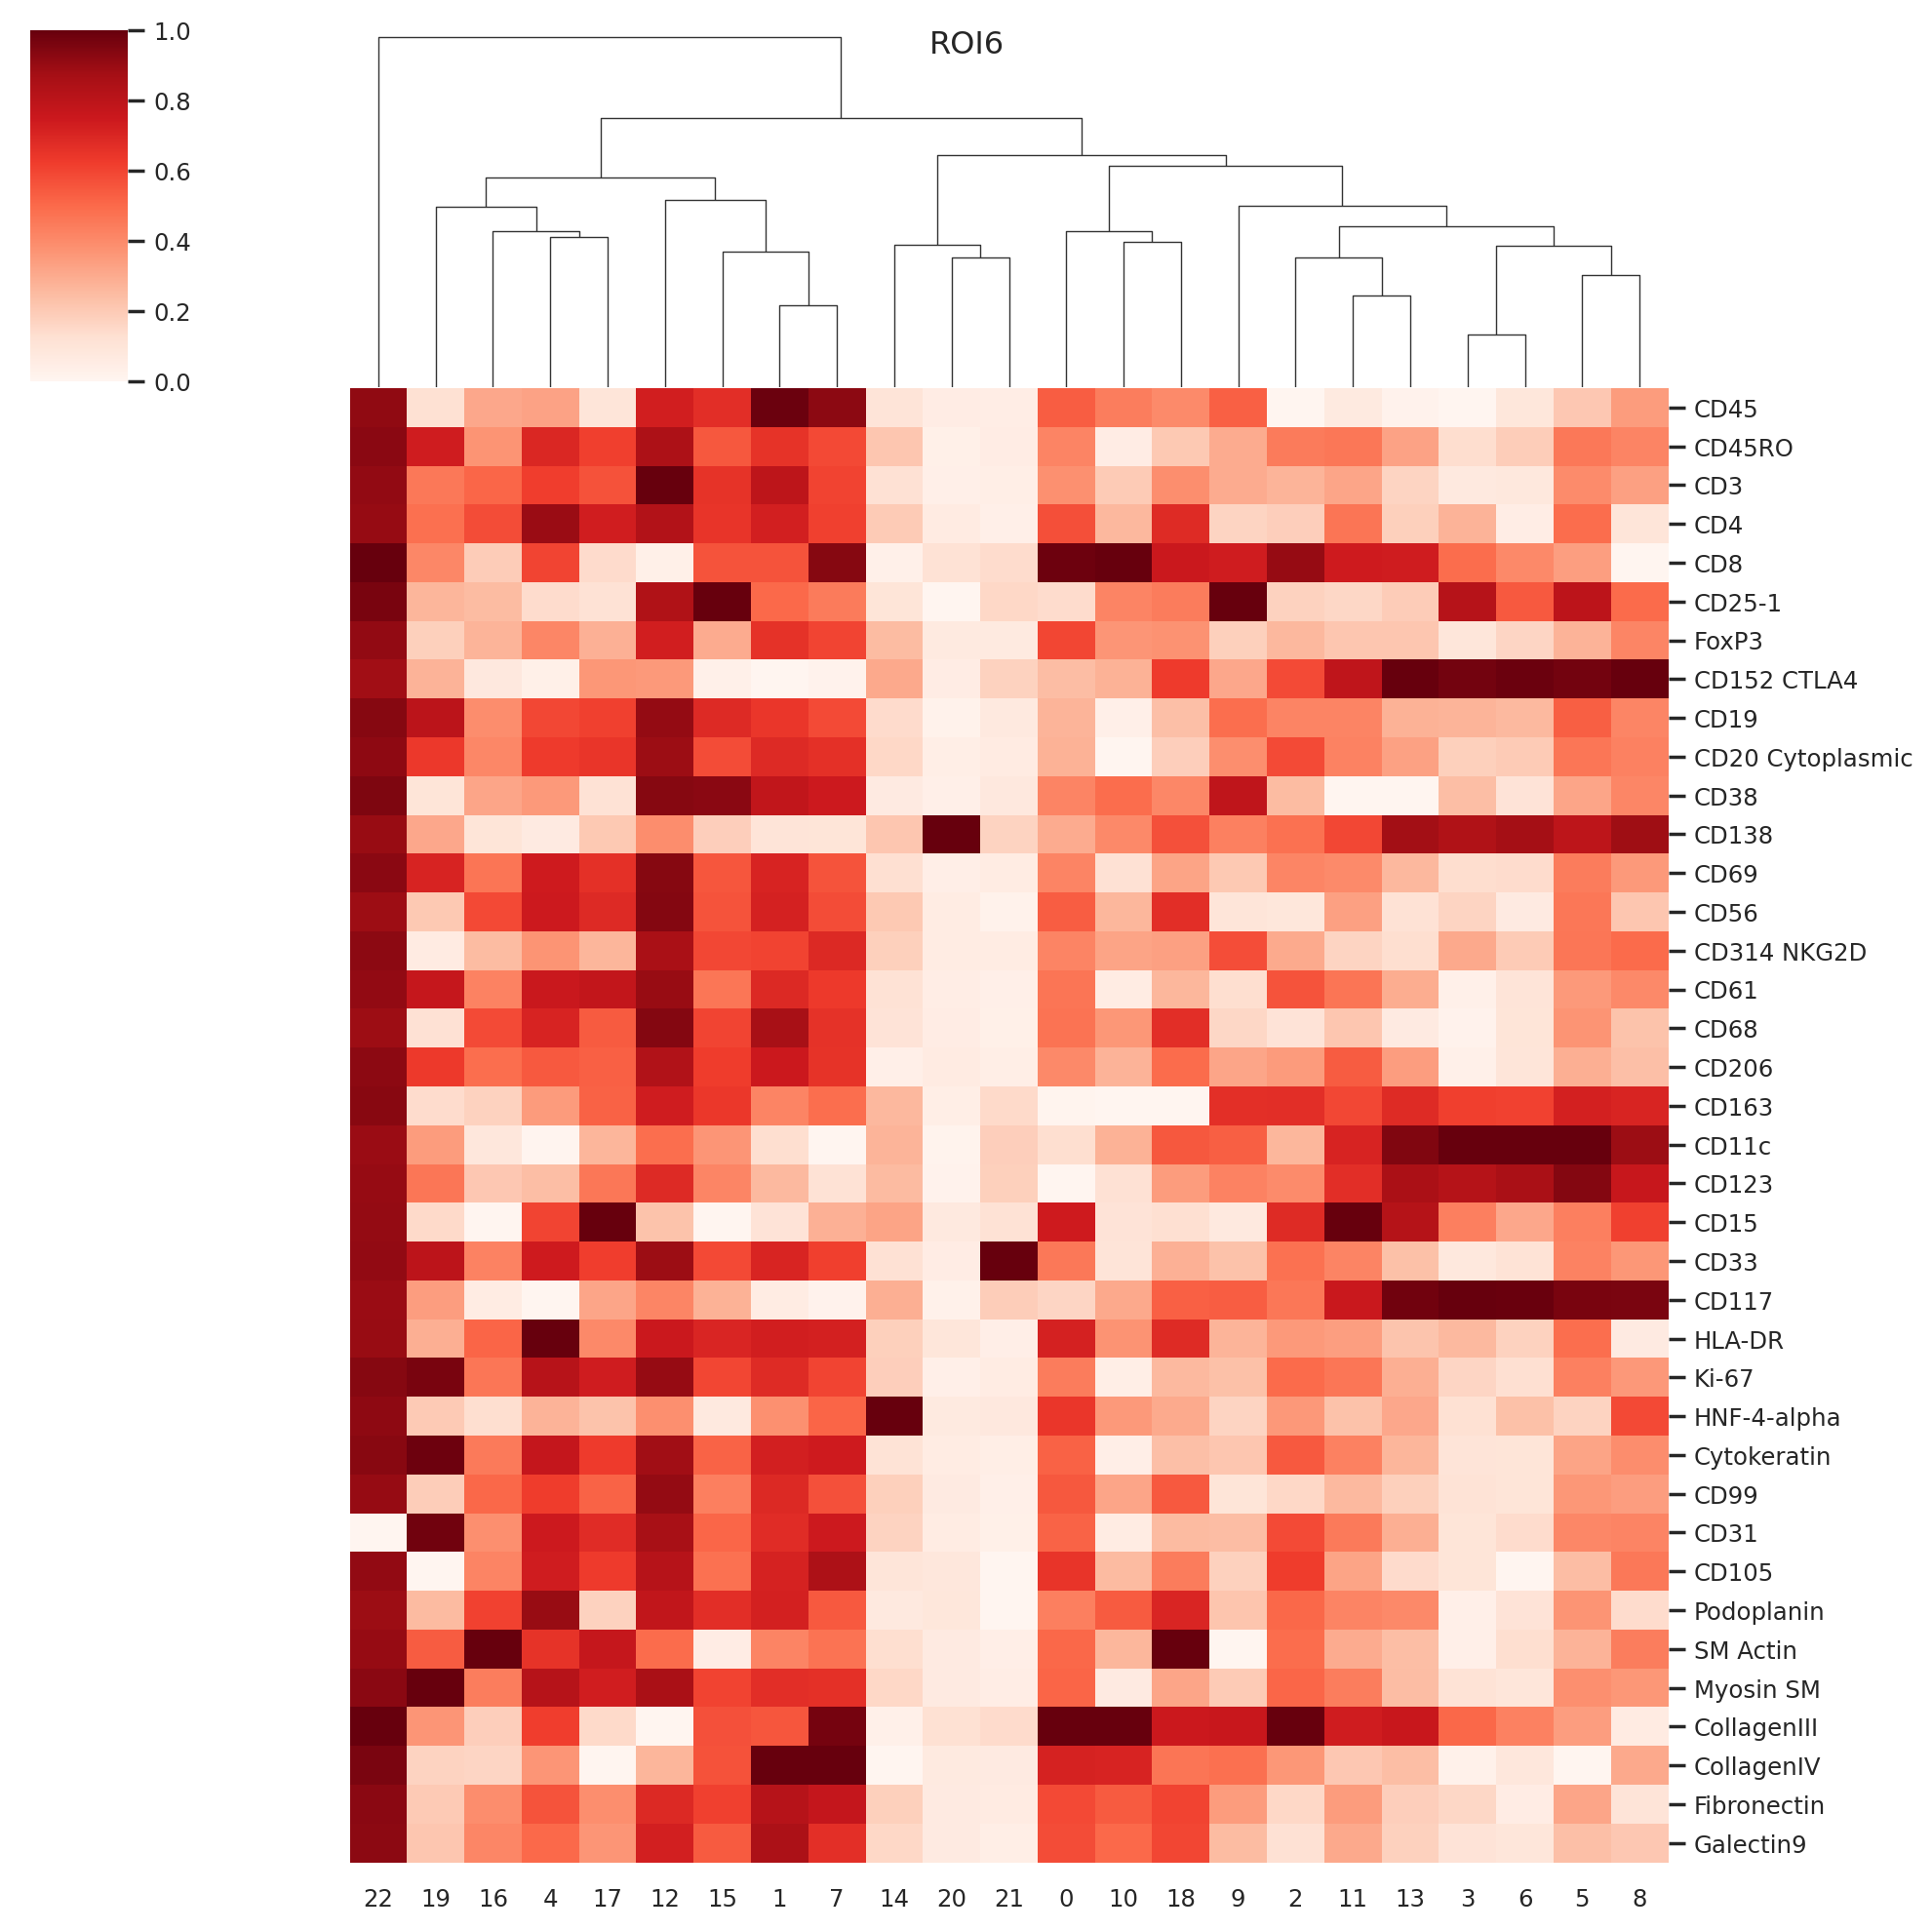

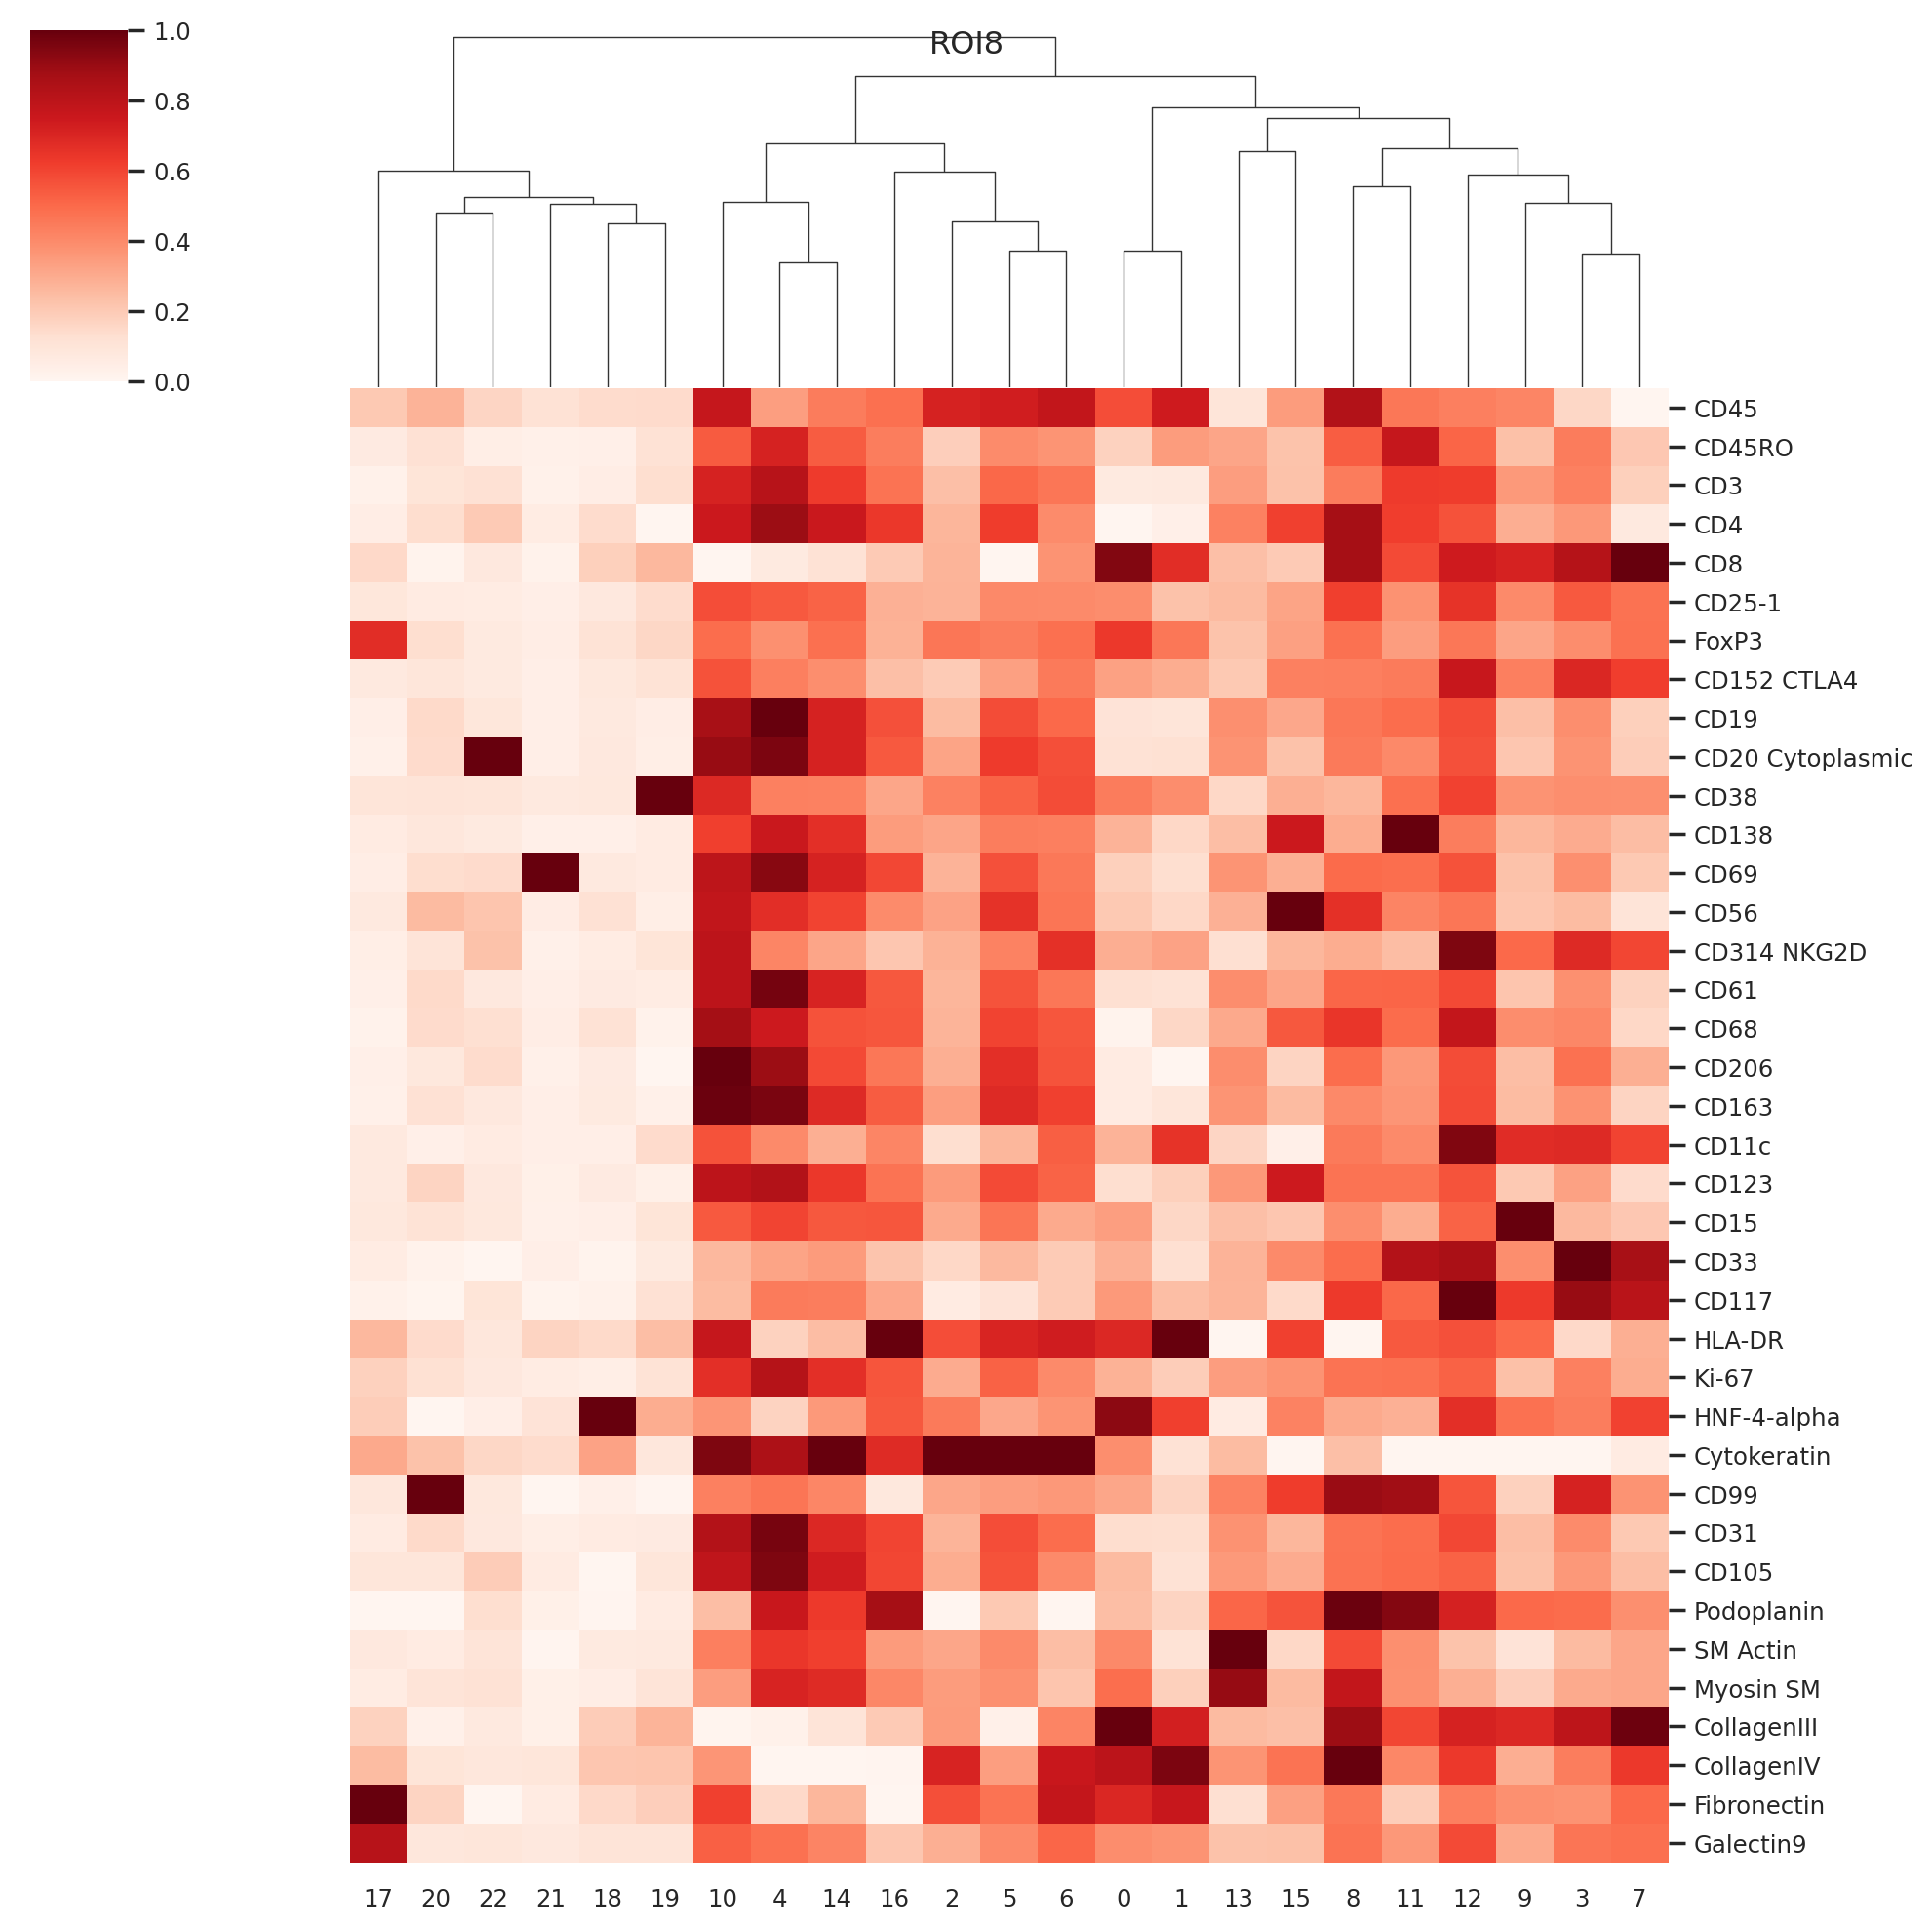

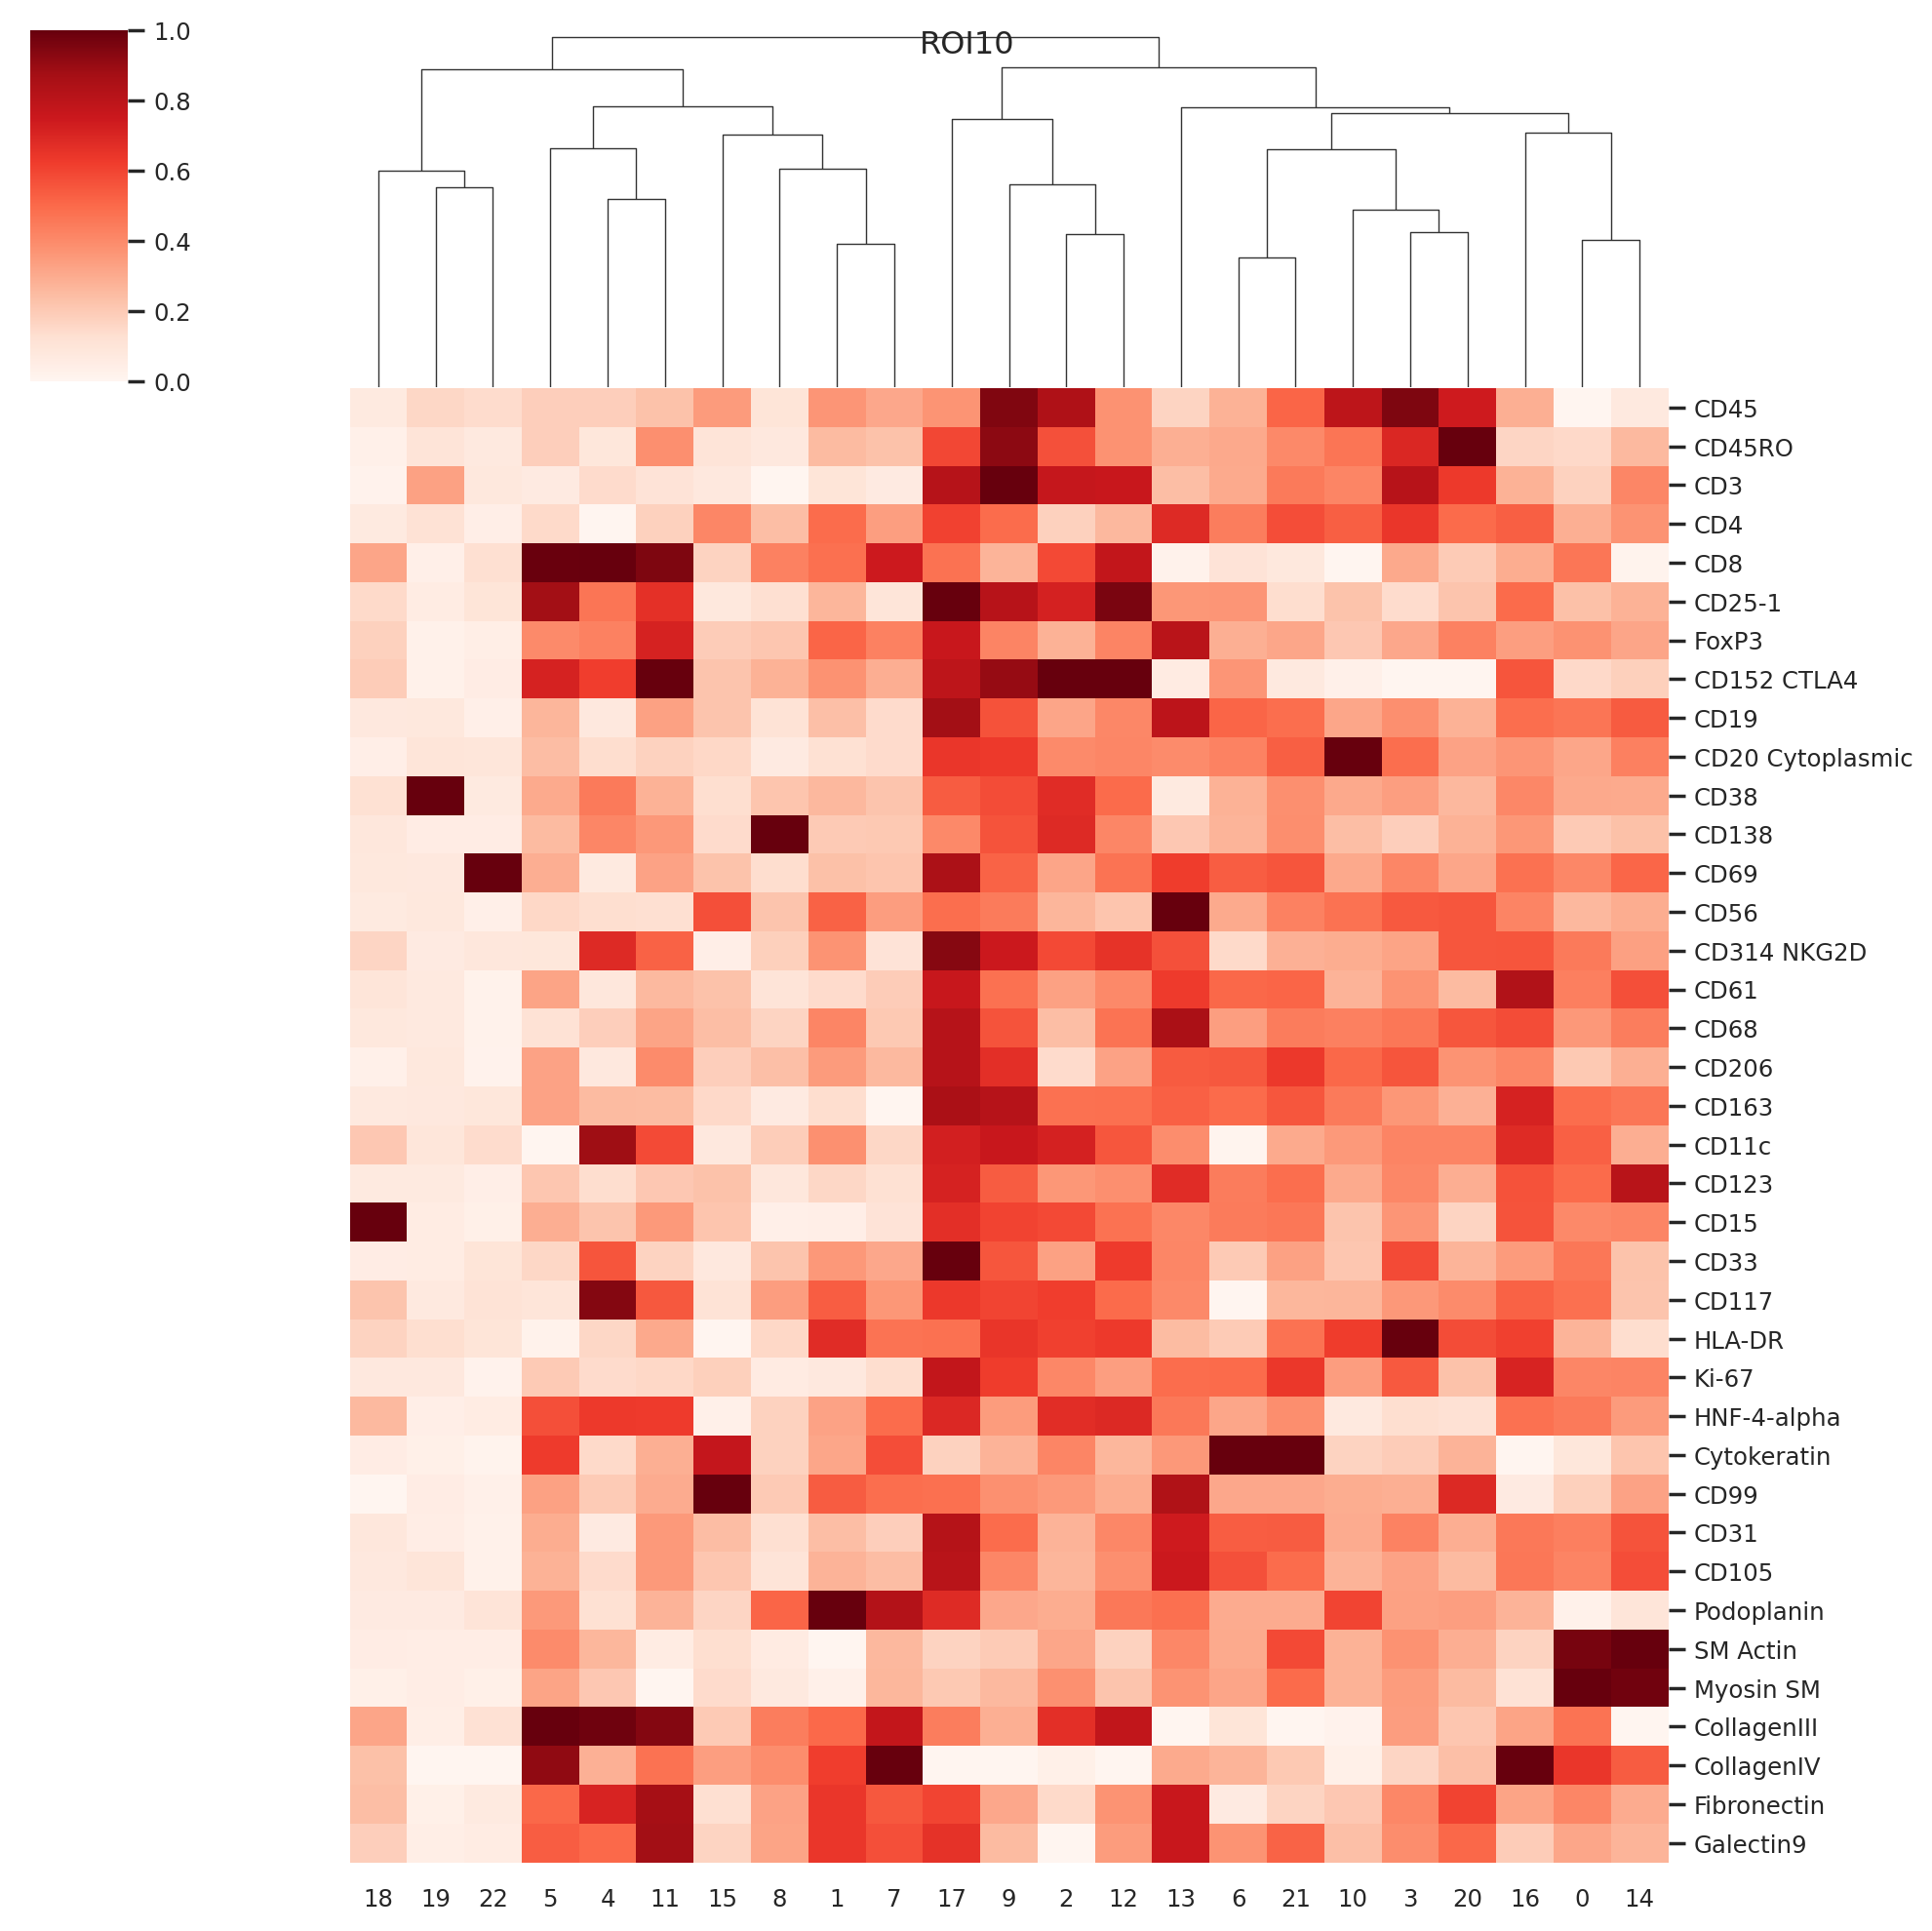

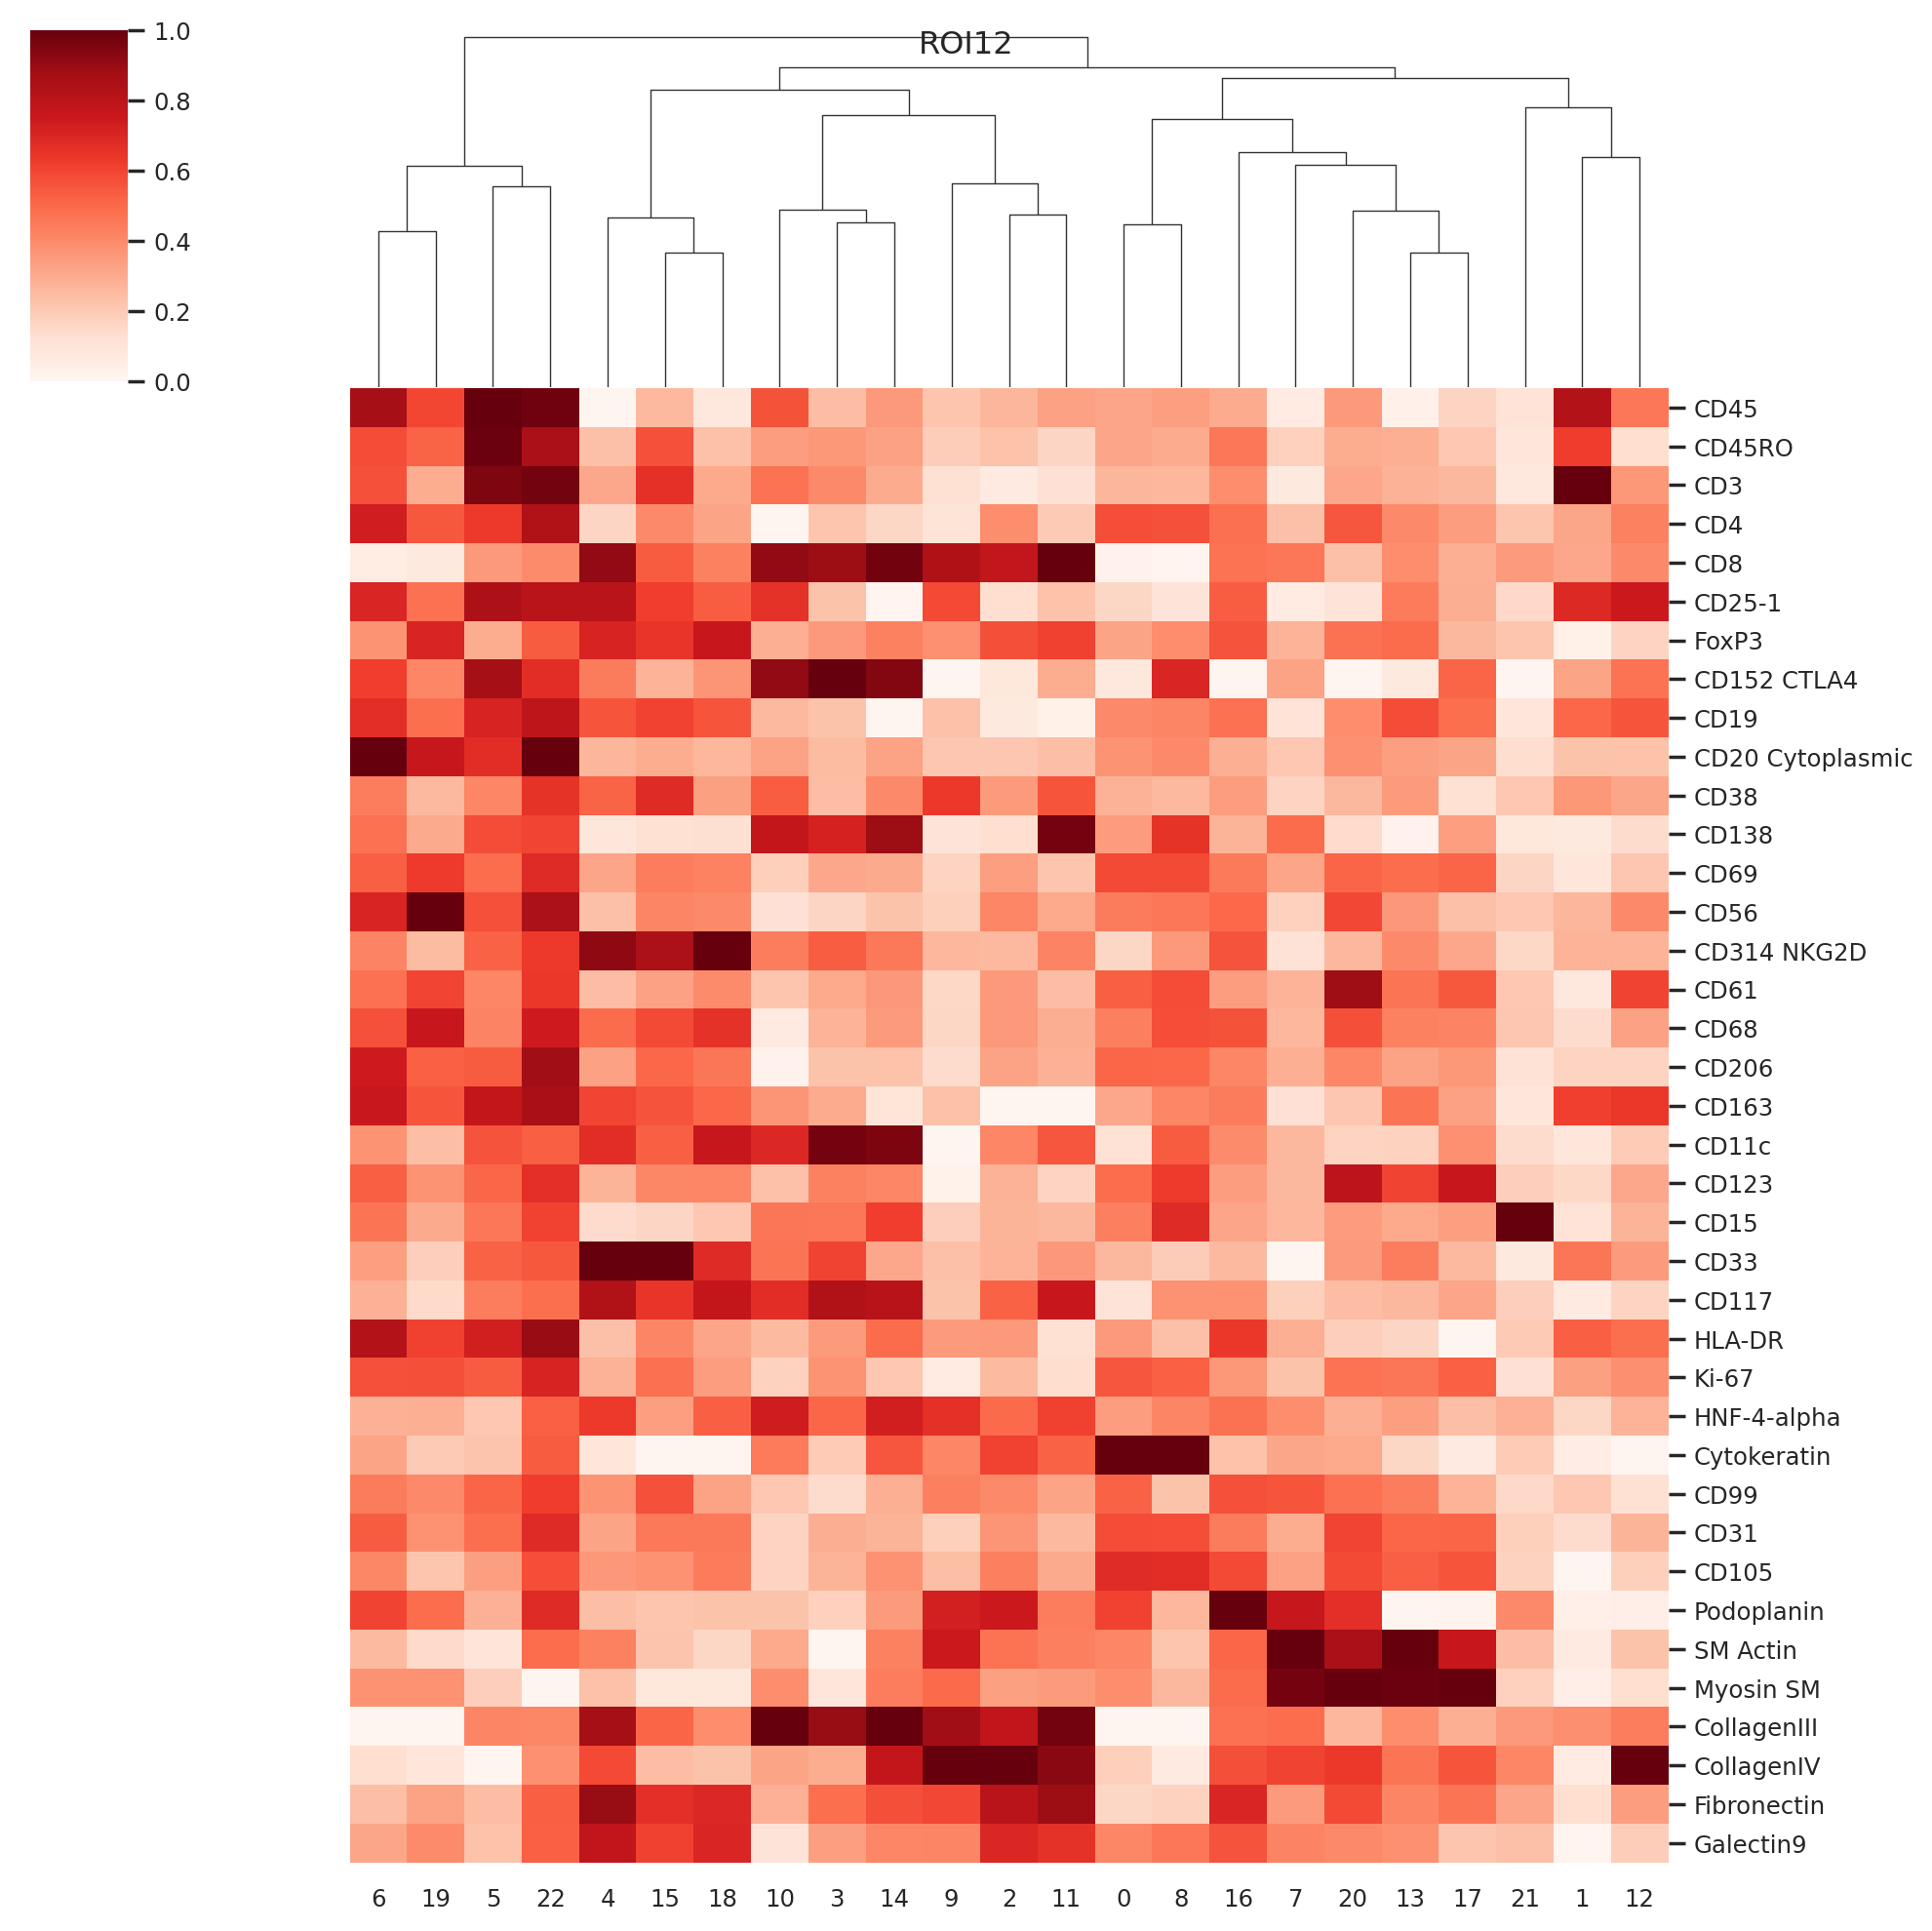

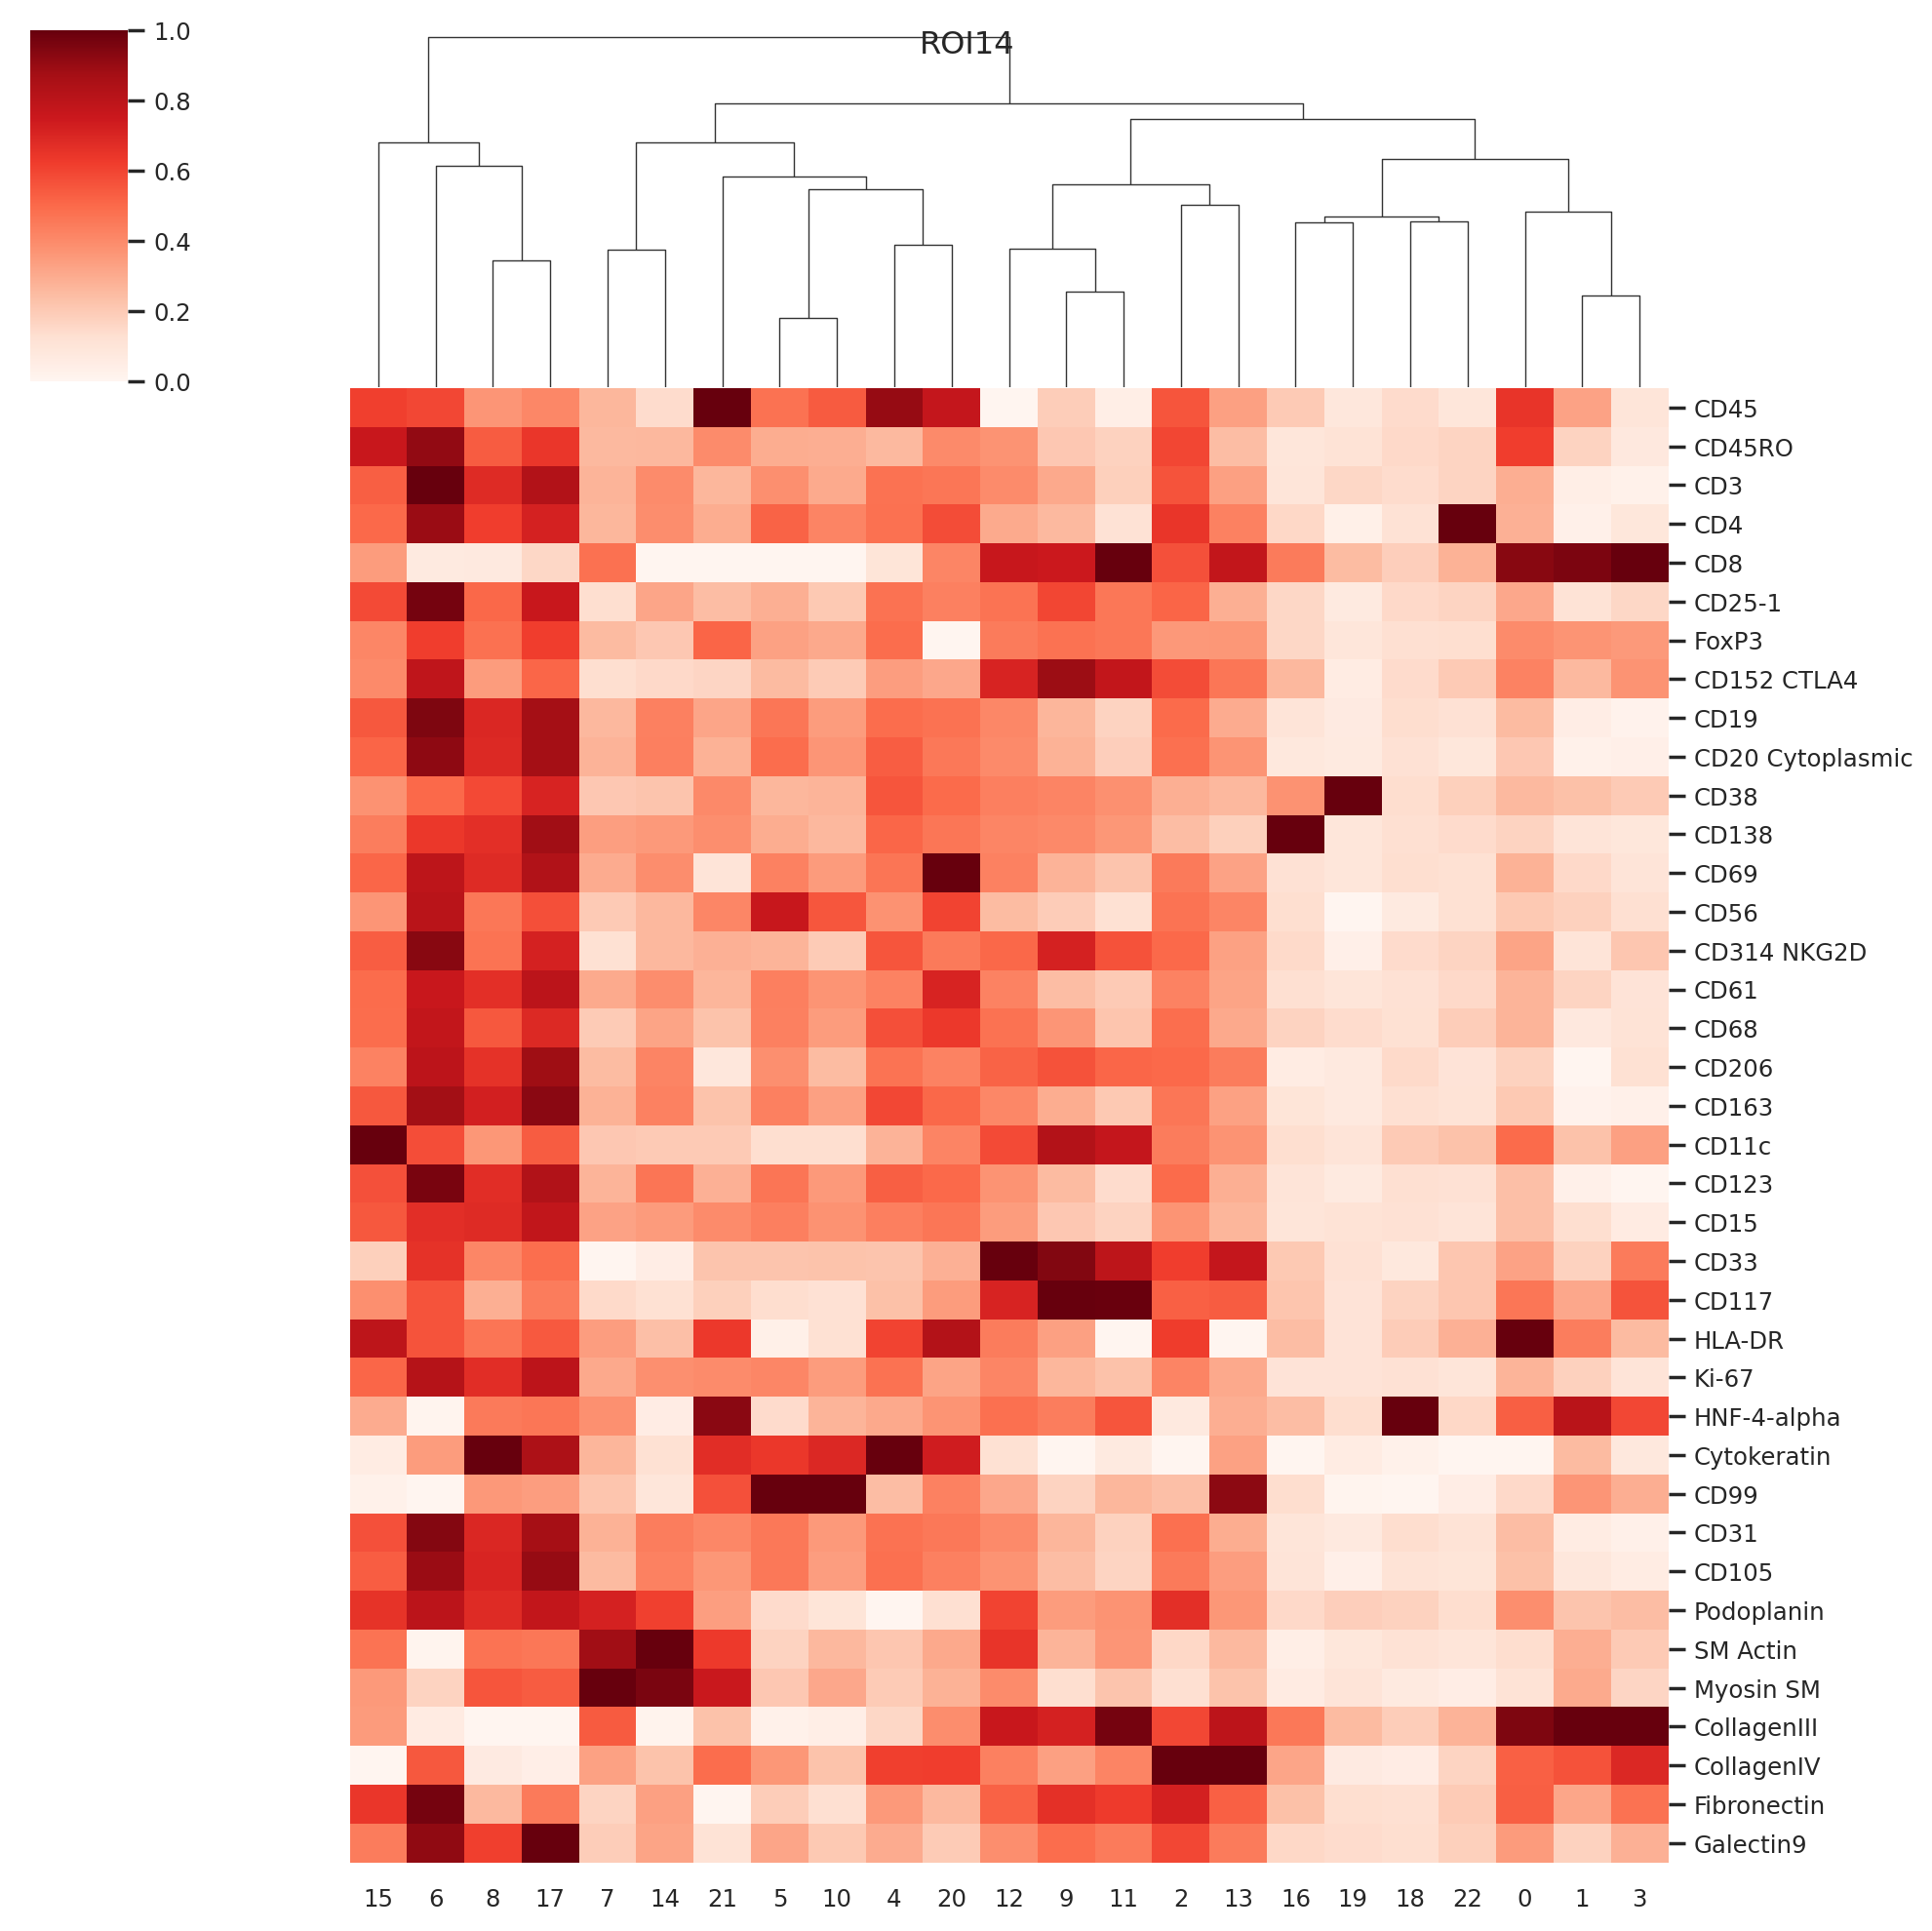

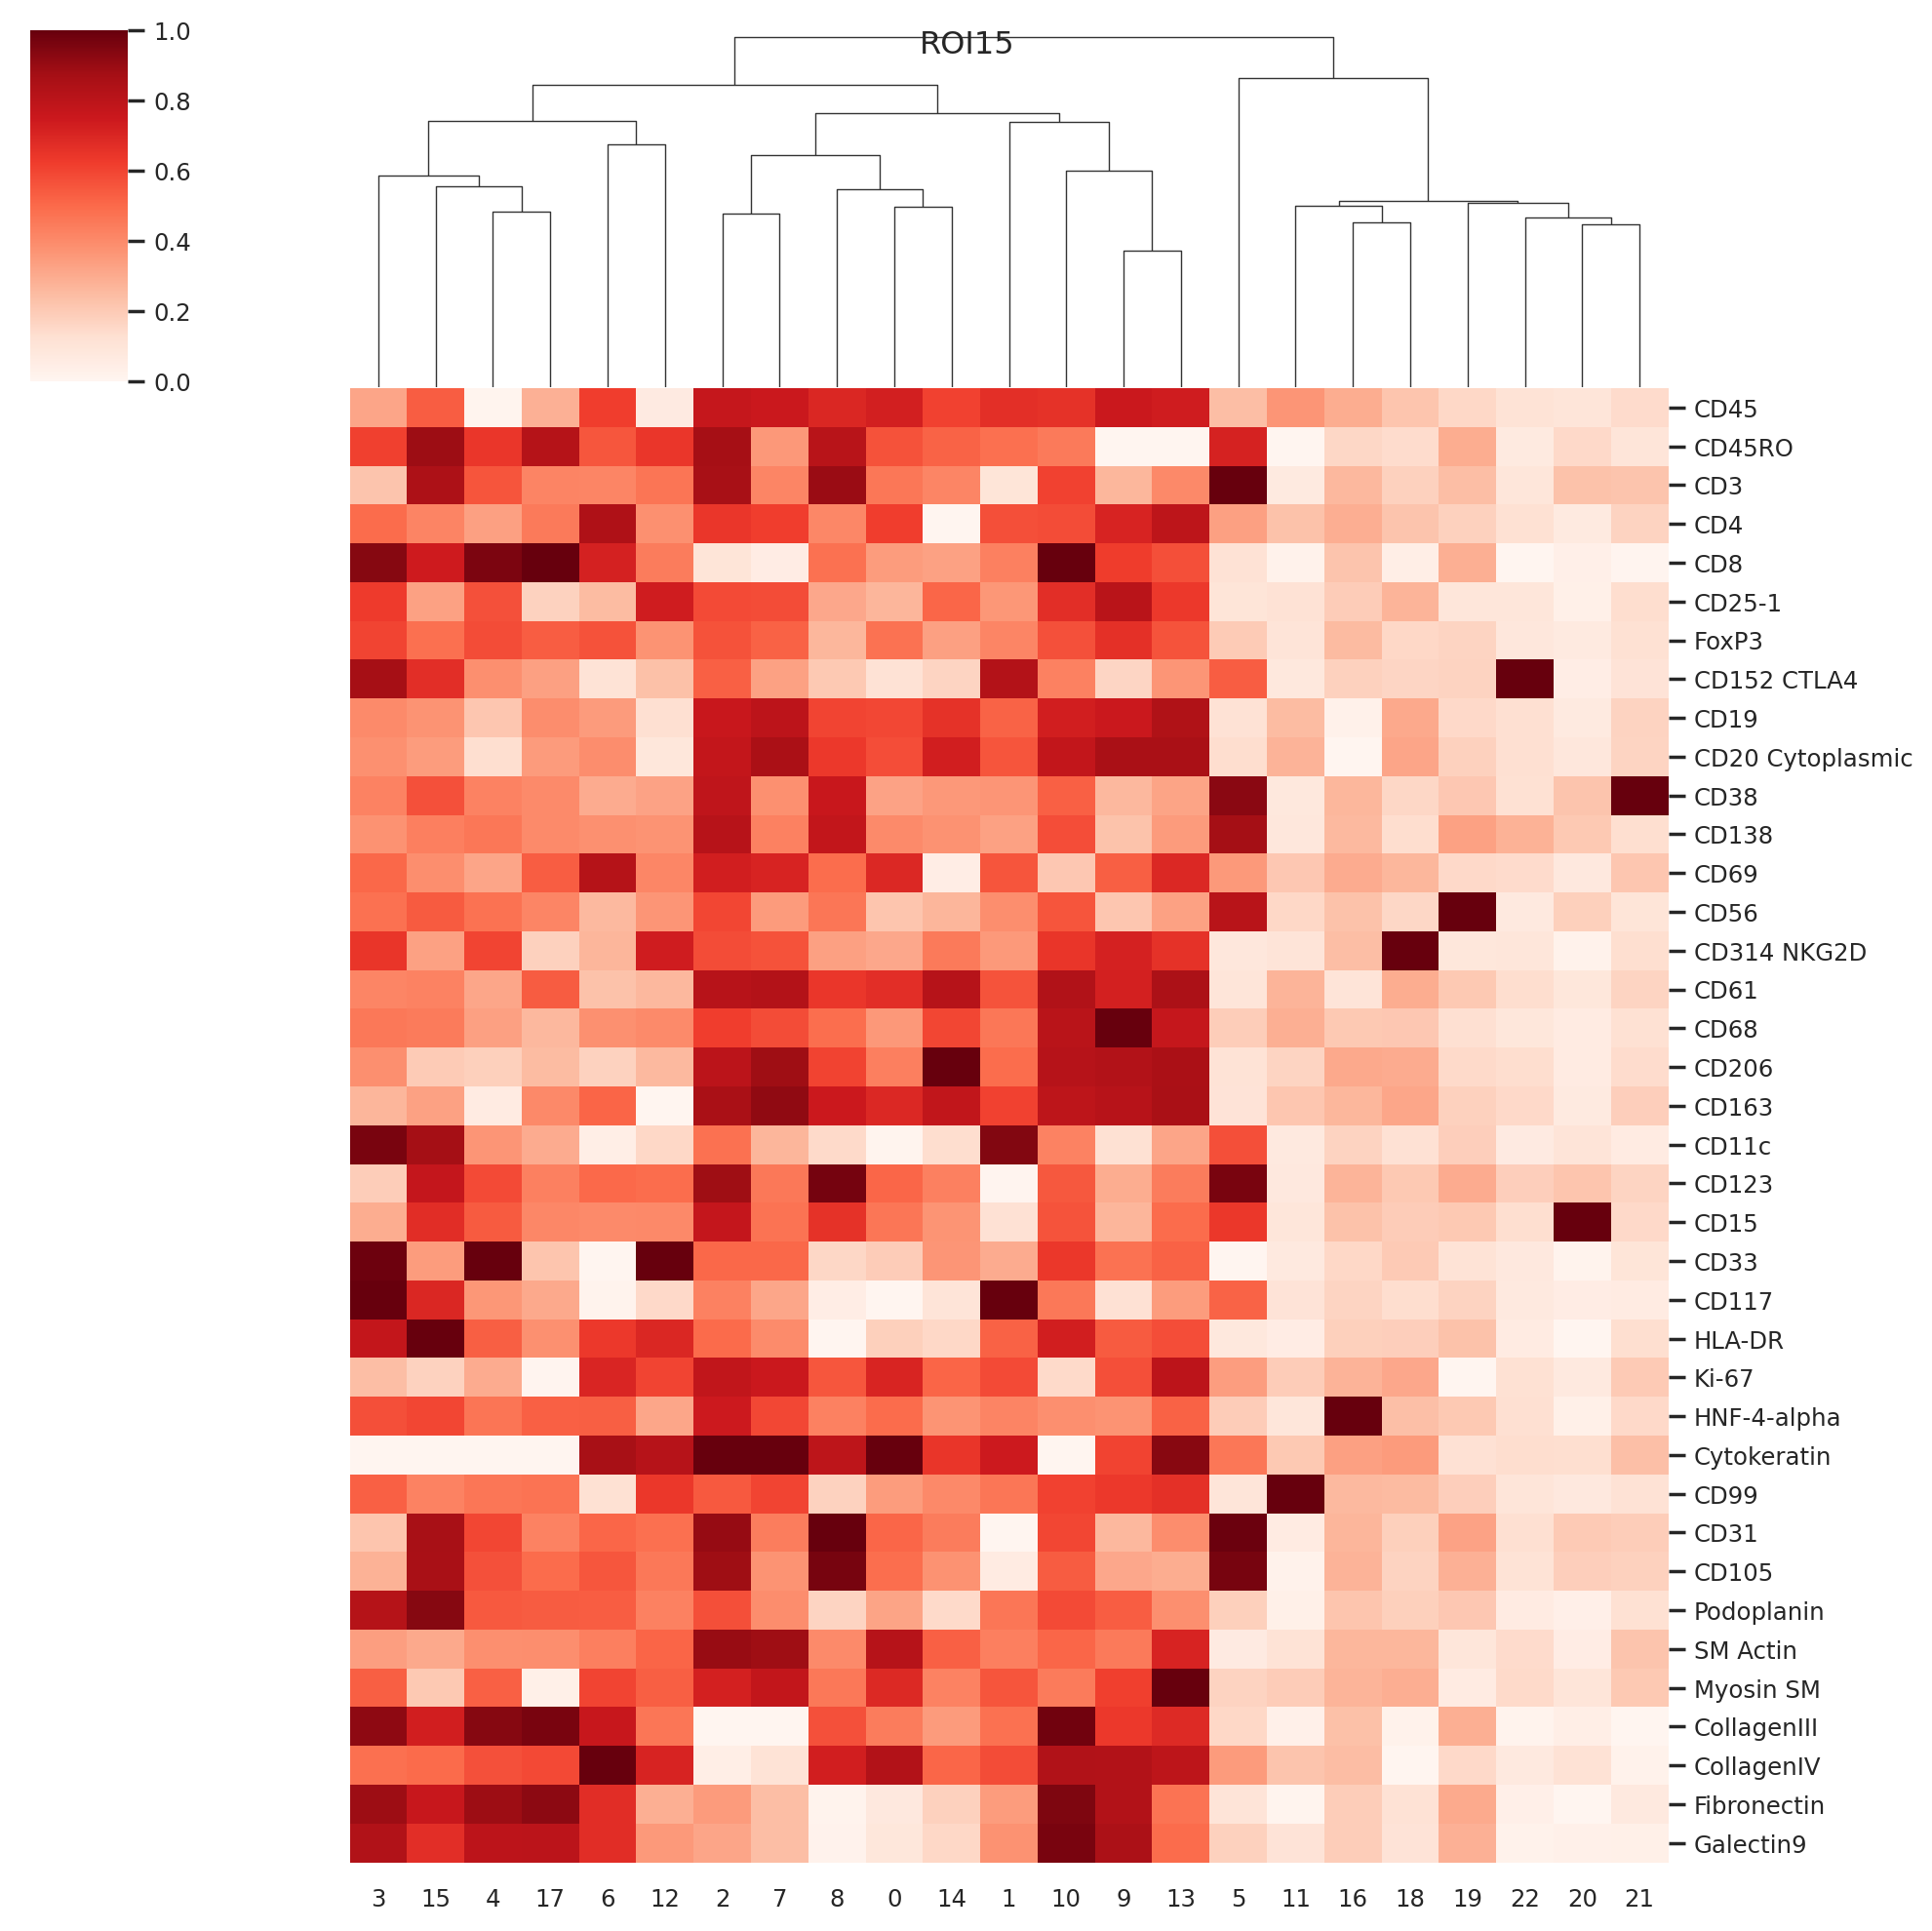

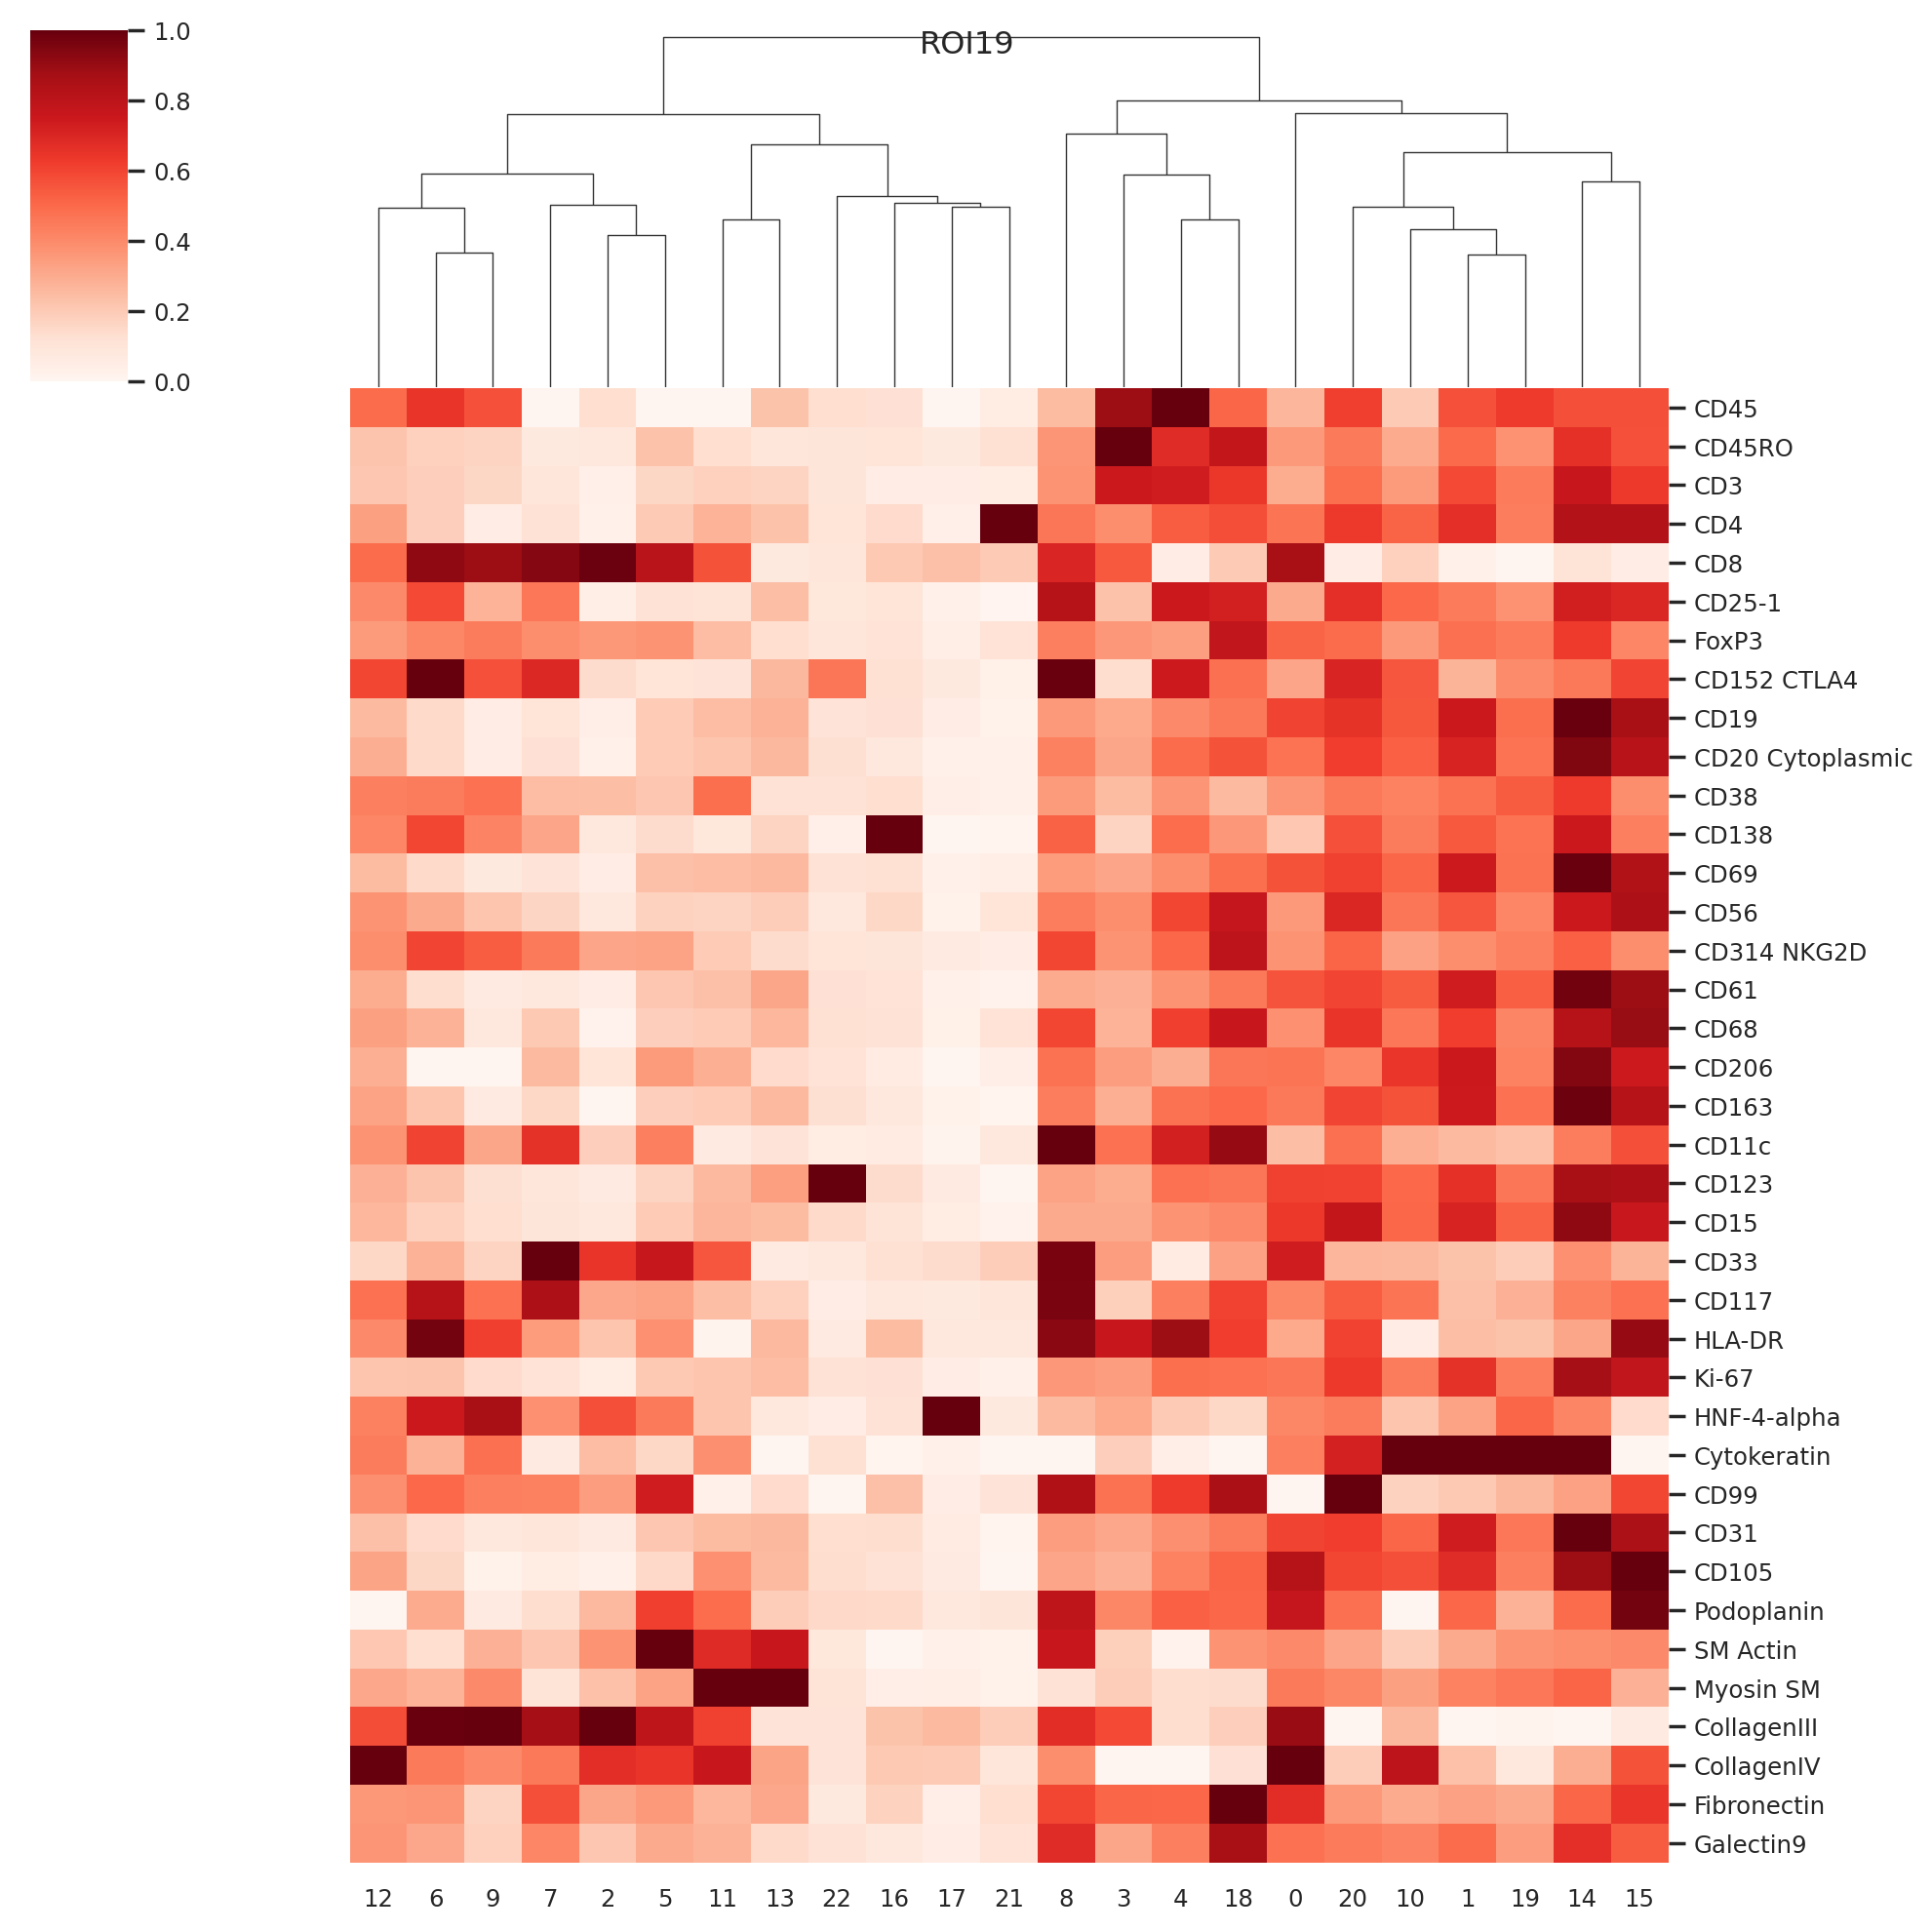

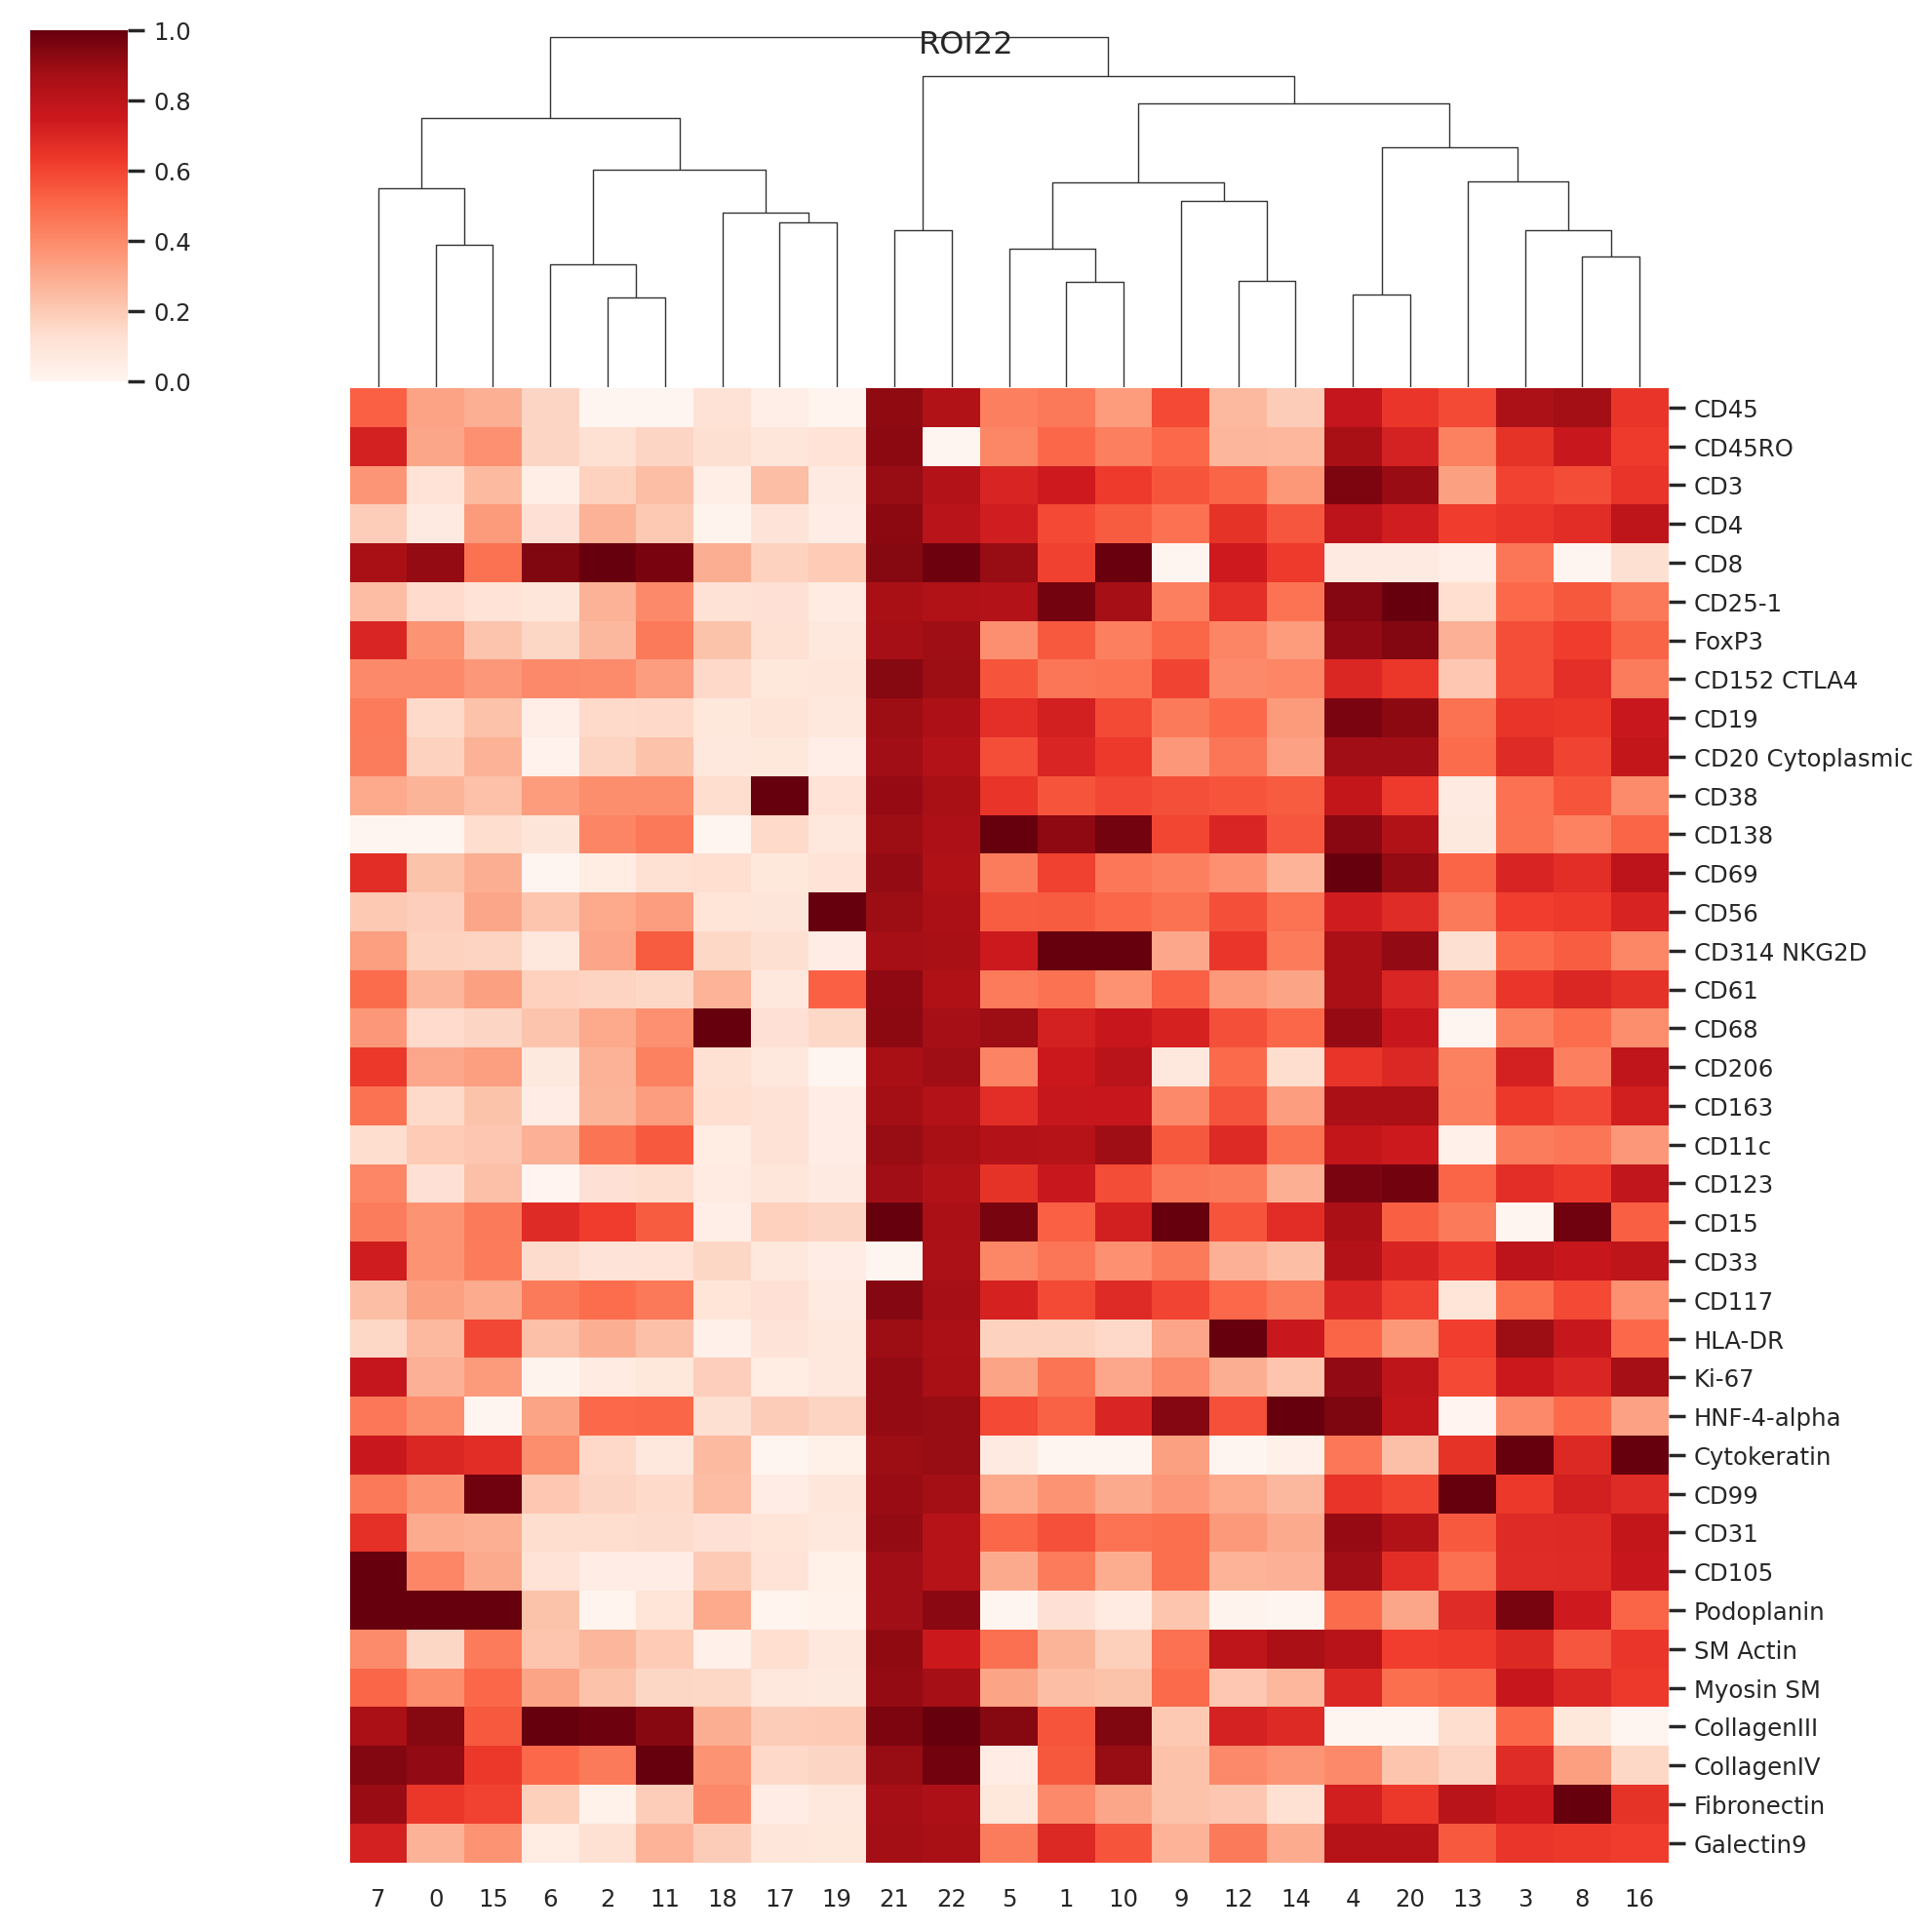

In [17]:
plotHeatmap(ROI6_immune, 'ROI6')
plotHeatmap(ROI8_immune, 'ROI8')
plotHeatmap(ROI10_immune, 'ROI10')
plotHeatmap(ROI12_immune, 'ROI12')
plotHeatmap(ROI14_immune, 'ROI14')
plotHeatmap(ROI15_immune, 'ROI15')
plotHeatmap(ROI19_immune, 'ROI19')
plotHeatmap(ROI22_immune, 'ROI22')

In [18]:
# save results in:
import os
# Make a single directory
if not os.path.exists('data'):
    os.mkdir('data')


AnnData.write(P_ROI6_zscore, filename='data/ROI6.h5ad')
AnnData.write(P_ROI8_zscore, filename='data/ROI8.h5ad')
AnnData.write(P_ROI10_zscore, filename='data/ROI10.h5ad')
AnnData.write(P_ROI12_zscore, filename='data/ROI12.h5ad')
AnnData.write(P_ROI14_zscore, filename='data/ROI14.h5ad')
AnnData.write(P_ROI15_zscore, filename='data/ROI15.h5ad')
AnnData.write(P_ROI19_zscore, filename='data/ROI19.h5ad')
AnnData.write(P_ROI22_zscore, filename='data/ROI22.h5ad')